# Using Data Science to understand the Hollywood Gender Gap

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline  

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from turicreate import SFrame
import turicreate.aggregate as agg

In [5]:
import numpy as np

In [6]:
from subs2graph.consts import TEMP_PATH, DATA_PATH

In [7]:
import glob

## Introduction

In the past couple of years we have heard many stories about women discrimination is the film industry.
Even worse there was many reports of women sexual harassments in Hollywood which has led to the rise of the MeToo Movement.
This paper, investigates the gender gap in Hollywood utilizing data science techniques. 

## File Genartion

In [11]:
from subs2graph.videos_sn_creator import generate_actors_file
generate_actors_file()

/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/dogpile/cache/util.py:31: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(fn)


KeyboardInterrupt: 

## Analysis


<img src="https://i.kym-cdn.com/entries/icons/mobile/000/027/456/kowalski.jpg" />


In [34]:
from subs2graph.graph_analyzer import *

### Load actors-movies list

In [13]:
actors = pd.read_csv(f"{TEMP_PATH}/actors.csv",index_col=0 )
actors = actors.drop(["endYear", "isAdult", "knownForTitles", "originalTitle", "titleType"], axis=1)

In [14]:
len(actors["nconst"].unique())

3698

In [15]:
len(actors["tconst"].unique())

17534

In [16]:
len(actors[actors["gender"]=="F"]["nconst"].unique())

1299

In [17]:
actors.head(1)

,averageRating,birthYear,birthYear.1,characters,count,deathYear,deathYear.1,gender,gender.1,genres,...,nconst,path,primaryName,primaryName.1,primaryProfession,primaryProfession.1,primaryTitle,runtimeMinutes,startYear,tconst
0,7.042857,1899,1899.0,['Guy Holden'],28,1987,1987.0,M,M,"Comedy,Musical,Romance",...,nm0000001,/storage/homedir/dima/Projects/subs2graph/temp...,Fred Astaire,Fred Astaire,"soundtrack,actor,miscellaneous",actor,The Gay Divorcee,107.0,1934.0,tt0025164


### Join with movies meta data

In [19]:
def analyze_actors():
    p = f"{TEMP_PATH}/movies/"
    res = []
    for i, a in tqdm(actors.iterrows()):
        g_pth = a["path"]
        try:
            with open(glob.glob(os.path.join(f"{g_pth}/json", f"*roles*"))[0]) as f:
                g = json_graph.node_link_graph(json.load(f))
                if g.number_of_nodes() < 6:
                    continue
                d = get_actor_features(g, a["primaryName"])
            res.append({**d, **a})
        except KeyError:
            pass

    return res

In [20]:
actors_features =  pd.DataFrame(analyze_actors())

42150it [08:23, 83.74it/s]


In [21]:
actors_features = actors_features.drop("count", axis=1)

In [22]:
actors_features = actors_features.drop(["birthYear.1","deathYear.1","gender.1","knownForTitles.1","primaryName.1","primaryProfession.1"], axis=1)

In [23]:
len(actors_features)

25527

In [24]:
actors_features = actors_features.sort_values("nconst")

### Feature Engineering 

Graph based:

In [157]:
graph_features = ["betweenness", "closeness", 'clustering','degree', 'degree_centrality','total_weight']

Date based features:

In [26]:
actors_features = actors_features.replace("\\N", 0)


In [27]:
actors_features = actors_features.dropna()
actors_features["deathYear"] = actors_features["deathYear"].astype(int)
actors_features["birthYear"] = actors_features["birthYear"].astype(int)
actors_features["startYear"] = actors_features["startYear"].astype(int)
actors_features["age_filming"] = actors_features["startYear"] - actors_features["birthYear"]

In [28]:
actors_features = actors_features[actors_features["birthYear"]!=0]

Multiple categories to onehot

In [29]:
# actors_features["primaryProfession"] = actors_features["primaryProfession"].apply(lambda x: x.split(","))
actors_features["genres"] = actors_features["genres"].apply(lambda x: x.split(","))

In [416]:
genres = set()
for genre in set().union(*actors_features.genres.values):
    actors_features[genre] = actors_features.apply(lambda _: int(genre in _.genres), axis=1)
    genres.add(genre)
    
# for prof in set().union(*actors_features.primaryProfession.values):
#     actors_features[prof] = actors_features.apply(lambda _: int(prof in _.primaryProfession), axis=1)

NameError: name 'actors_features' is not defined

Gender to numeric - Male=1 Female=0

In [31]:
actors_features["gender_num"] = actors_features["gender"].apply(lambda x: 1 if x == "M" else 0)

### ML

In [158]:
df = actors_features.drop(["gender","genres","path","primaryName","primaryProfession","primaryTitle", "tconst", "characters"], axis=1)

In [159]:
male =  df[df["gender_num"]==1]
female = df[df["gender_num"]==0]

In [160]:
male["nconst"].nunique()

2209

In [161]:
female["nconst"].nunique()

1231

In [45]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

In [46]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())
 

def print_score(m, X_train, y_train, X_valid, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

Imbalanced Dataset:

In [38]:
len(actors_features[actors_features["gender"]=="M"])

17122

In [39]:
len(actors_features[actors_features["gender"]=="F"])

8307

In [60]:

# balanced_df = male.sample(len(female)).append(female)
# balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [42]:
df.to_csv("Gender_train.csv",index=False)

In [61]:
male_sample = male.sort_values("nconst")[:len(female)]
n_valid = 8000
male_sample = male_sample.drop(["nconst", "gender_num"], axis=1)
female_sample = female.drop(["nconst", "gender_num"], axis=1)
male_train, male_valid = split_vals(male_sample, n_valid//2)
female_train, female_valid = split_vals(female_sample, n_valid//2)

In [62]:
X_train = male_train.append(female_train)
X_valid = male_valid.append(female_valid)
y_train = np.concatenate((np.ones(len(male_train)), np.zeros(len(female_train))))
y_valid = np.concatenate((np.ones(len(male_valid)), np.zeros(len(female_valid))))

In [63]:
# y = balanced_df.pop("gender_num")
# n_valid = 2000  # same as Kaggle's test set size
# n_trn = len(balanced_df)-n_valid
# X_train, X_valid = split_vals(balanced_df, n_trn)
# y_train, y_valid = split_vals(y, n_trn)

In [64]:
# balanced_df.to_csv("../mf_balanced.csv", index=False)
# balanced_df[graph_features+["gender_num"]].to_csv("../mf_balanced_graph.csv", index=False)
# balanced_df.drop(graph_features, axis=1).to_csv("../mf_balanced_not_graph.csv", index=False)

In [66]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn import metrics

In [67]:
m = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=100)
m.fit(X_train[graph_features], y_train)
print_score(m, X_train[graph_features], y_train, X_valid[graph_features], y_valid)

[0.09219544457292887, 0.6976859825212489, 0.9915, 0.5132342697933596]


In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[graph_features])[:, 1])

0.5207636565956608

In [69]:
other_features = list(set(X_train.columns.values) - set(graph_features))
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train[other_features], y_train)
print_score(m, X_train[other_features], y_train, X_valid[other_features], y_valid)

/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.10185774393731682, 0.5521345538823834, 0.989625, 0.6951474344091014]


all

In [70]:
best_features = X_train.columns.values

In [83]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_features=0.5 , min_samples_split=5, min_samples_leaf=25)
m.fit(X_train[best_features], y_train)
print_score(m, X_train[best_features], y_train, X_valid[best_features], y_valid)

[0.4120072814890533, 0.5103980336703435, 0.83025, 0.739493847225447]


In [84]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[best_features])[:, 1])

0.8564513608415714

What is important?

In [73]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=best_features,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
age_filming,0.202820
birthYear,0.199139
averageRating,0.185799
pagerank_weight,0.061710
betweenness,0.061318
Action,0.043147
startYear,0.032128
total_weight,0.026612
degree,0.024525
runtimeMinutes,0.020493


In [74]:
best_features = list(feature_importances[feature_importances["importance"] > 0].index)

In [75]:
male_sample = male.sort_values("nconst")[:len(female)]
leave_one_data = male_sample.append(female)
leave_one_data = leave_one_data.sort_values("nconst")

groups = leave_one_data.nconst.astype("category").cat.codes
y = leave_one_data.pop("gender_num")
X = leave_one_data.drop(["nconst"], axis=1)


In [76]:
from sklearn.model_selection import LeaveOneGroupOut

# X = [1, 5, 10, 50, 60, 70, 80]
# y = [0, 1, 1, 2, 2, 2, 2]
# groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
loo_split = logo.split(X, y, groups=groups)
# count = 0
# for train, test in loo_split:
#     print("%s %s" % (train, test))
#     if count == 5:
#         break
#     count += 1

In [448]:
from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

In [450]:
from sklearn import model_selection
scoring = ['accuracy', 'precision', 'recall']
model = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=50)
results = model_selection.cross_validate(model, X, y, cv=loo_split, scoring=scoring)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

KeyboardInterrupt: 

In [77]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

In [78]:
def get_classification_metrics(l_test, prediction, probas):
    # fpr, tpr, thresholds = roc_curve(l_test, prediction)
    false_positive = float(
        len(np.where(l_test - prediction == -1)[0]))  # 0 (truth) - 1 (prediction) == -1 which is a false positive
    true_negative = float(
        len(np.where(l_test + prediction == 0)[0]))  # 0 (truth) - 0 (prediction) == 0 which is a true positive
    return {"auc": roc_auc_score(l_test, probas),
            "recall": recall_score(l_test, prediction),
            "precision": precision_score(l_test, prediction),
            "accuracy": accuracy_score(l_test, prediction),
            "fpr": false_positive / (true_negative + false_positive),
            "tnr": true_negative / (true_negative + false_positive)
            }

In [85]:
def cross_validate(X, y):
    # clf = SkLearner(clone(self._classifier), self._label_encoder)
    roc_auc, recall, precision, accuracy, fpr, tpr, tnr = [], [], [], [], [], [], []
    all_probas =[]
    for train_index, test_index in loo_split:
        f_train, f_test = X.iloc[train_index], X.iloc[test_index]
        l_train, l_test = y.iloc[train_index], y.iloc[test_index]
        # prediction = self.train_classifier(DataSet(f_train, l_train)).predict(f_test)
        clf = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_features=0.5 , min_samples_split=5, min_samples_leaf=25)
        clf.fit(f_train, l_train)
        probas = clf.predict_proba(f_test)[:, 1]
        all_probas.append(probas)
    # return {"auc": np.mean(roc_auc)}
    # print classification_report(l_test, prediction)
    # print "Predicted: 0   1"
    # print confusion_matrix(l_test, prediction)
    return all_probas
#     return {"auc": np.mean(roc_auc), "recall": np.mean(recall), "precision": np.mean(precision),
#             "accuracy": np.mean(accuracy), "fpr": np.mean(fpr), "tnr": np.mean(tnr)}

In [86]:
res = cross_validate(X,y)

In [87]:
res_p = np.concatenate(res)

In [88]:
prediction = np.where(res_p > 0.5, 1, 0)

In [89]:
len(res_p)

16614

In [90]:
get_classification_metrics(y,prediction ,res_p)

{'auc': 0.829733210103914,
 'recall': 0.7717587576742506,
 'precision': 0.7273655547991831,
 'accuracy': 0.741242325749368,
 'fpr': 0.28927410617551463,
 'tnr': 0.7107258938244854}

### Statistics

#### Males

In [91]:
male.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,17122.0,6.436236,0.523086,3.466667,6.129851,6.479167,6.790000,8.372727
betweenness,17122.0,0.167159,0.203016,0.000000,0.010686,0.083175,0.258835,1.000000
betweenness_weight,17122.0,0.171464,0.195424,0.000000,0.003101,0.107178,0.266667,1.000000
birthYear,17122.0,1950.233034,24.642591,1863.000000,1935.000000,1955.500000,1969.000000,2006.000000
closeness,17122.0,0.753341,0.166146,0.047619,0.631579,0.750000,0.882353,1.000000
clustering,17122.0,0.565592,0.285574,0.000000,0.355556,0.558333,0.800000,1.000000
deathYear,17122.0,491.064712,858.174560,0.000000,0.000000,0.000000,0.000000,2018.000000
degree,17122.0,8.344528,5.581122,1.000000,5.000000,7.000000,11.000000,86.000000
degree_centrality,17122.0,0.647296,0.266959,0.026316,0.444444,0.687500,0.873992,1.400000
movie_rating,17122.0,6.552716,0.971158,1.800000,6.000000,6.600000,7.200000,9.400000


#### Feamles

In [92]:
female.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,8307.0,6.406262,0.508781,3.716667,6.100000,6.422917,6.731174,8.214286
betweenness,8307.0,0.125039,0.170647,0.000000,0.003704,0.049145,0.183750,1.000000
betweenness_weight,8307.0,0.148914,0.176290,0.000000,0.000000,0.088889,0.231682,1.000000
birthYear,8307.0,1960.026724,22.631790,1865.000000,1948.000000,1966.000000,1976.000000,1999.000000
closeness,8307.0,0.728025,0.160091,0.043478,0.612903,0.722222,0.846154,1.000000
clustering,8307.0,0.608106,0.287714,0.000000,0.400000,0.619048,0.833333,1.000000
deathYear,8307.0,281.349103,694.258423,0.000000,0.000000,0.000000,0.000000,2018.000000
degree,8307.0,7.625737,4.944934,1.000000,4.000000,7.000000,10.000000,49.000000
degree_centrality,8307.0,0.604876,0.263289,0.019231,0.400000,0.625000,0.823529,1.400000
movie_rating,8307.0,6.501035,0.936810,2.100000,5.900000,6.600000,7.200000,9.200000


#### Gender Gap

In [93]:
df = actors_features.drop(["genres","nconst","path","primaryName","primaryProfession","primaryTitle", "tconst"], axis=1)

In [94]:
pd.pivot_table(df[df["startYear"] > 1990], index=["Western","gender"]).T

Western                       0                         1             
gender                        F            M            F            M
Action                 0.156709     0.262714     0.193548     0.294118
Adventure              0.113485     0.160562     0.064516     0.152941
Animation              0.030874     0.036803     0.000000     0.000000
Biography              0.070761     0.072112     0.000000     0.011765
Comedy                 0.434913     0.388406     0.161290     0.211765
Crime                  0.163718     0.243215     0.032258     0.023529
Documentary            0.000501     0.000878     0.000000     0.000000
Drama                  0.620661     0.567940     0.612903     0.529412
Family                 0.054573     0.045762     0.000000     0.011765
Fantasy                0.064920     0.064295     0.000000     0.023529
Film-Noir              0.000000     0.000000     0.000000     0.000000
History                0.025534     0.036891     0.000000     0.035294
Horror                 0.083611     0.073957     0.000000     0.000000
Music                  0.031375     0.025121     0.000000     0.000000
Musical                0.011682     0.007027     0.000000     0.000000
Mystery                0.095127     0.085112     0.000000     0.000000
Romance                0.263518     0.167238     0.225806     0.070588
Sci-Fi                 0.048565     0.059113     0.000000     0.000000
Sport                  0.017190     0.027931     0.000000     0.000000
Thriller               0.149032     0.178656     0.161290     0.141176
War                    0.011182     0.017830     0.000000     0.000000
age_filming           36.275033    43.367501    35.741935    47.035294
averageRating          6.270793     6.307961     6.289227     6.312387
betweenness            0.129670     0.170290     0.146103     0.184226
betweenness_weight     0.151332     0.173234     0.182712     0.204177
birthYear           1970.441589  1963.084321  1972.741935  1961.094118
closeness              0.716614     0.741773     0.725413     0.720899
clustering             0.591837     0.551481     0.536952     0.515899
deathYear             18.447931    88.665086     0.000000    47.282353
degree                 7.863985     8.747826     8.096774     8.435294
degree_centrality      0.586755     0.629322     0.628779     0.606943
gender_num             0.000000     1.000000     0.000000     1.000000
movie_rating           6.324766     6.361651     6.129032     6.323529
pagerank               0.111309     0.120477     0.120504     0.126409
pagerank_weight        0.133068     0.150769     0.142084     0.155208
runtimeMinutes       107.951602   109.339394   111.225806   110.000000
startYear           2006.716622  2006.451823  2008.483871  2008.129412
total_weight         166.410714   203.561792   151.290323   196.447059

In [95]:
temp_df = pd.DataFrame()
res = []
for g in genres:
    res.append(pd.pivot_table(df, index=[g,"gender"], aggfunc=np.mean).drop(list(genres - {g}),axis=1))

In [96]:
genre_age_gap = pd.concat(res, axis=1, sort=False, keys=list(genres)).T[1]

In [97]:
genre_age_gap["gap"] = genre_age_gap["M"] - genre_age_gap["F"]

In [98]:
genre_age_gap

gender                                  F            M         gap
Thriller  age_filming           34.939207    44.442501    9.503294
          averageRating          6.287053     6.345905    0.058851
          betweenness            0.127986     0.164685    0.036699
          betweenness_weight     0.148145     0.171552    0.023408
          birthYear           1965.280176  1954.602531  -10.677646
          closeness              0.732628     0.746365    0.013737
          clustering             0.611598     0.565968   -0.045630
          deathYear            161.769163   331.239672  169.470510
          degree                 7.252863     8.106066    0.853203
          degree_centrality      0.615712     0.639322    0.023610
          gender_num             0.000000     1.000000    1.000000
          movie_rating           6.311278     6.369818    0.058540
          pagerank               0.118352     0.124380    0.006028
          pagerank_weight        0.142451     0.152828    0.010377
          runtimeMinutes       108.041410   108.480834    0.439424
          startYear           2000.219383  1999.045032   -1.174352
          total_weight         157.229956   185.491999   28.262043
Musical   age_filming           33.025000    40.637462    7.612462
          averageRating          6.733482     6.721735   -0.011747
          betweenness            0.136842     0.118245   -0.018597
          betweenness_weight     0.154664     0.143455   -0.011209
          birthYear           1939.635000  1925.613293  -14.021707
          closeness              0.821074     0.804555   -0.016518
          clustering             0.662664     0.677494    0.014830
          deathYear            894.590000  1288.120846  393.530846
          degree                 7.250000     6.921450   -0.328550
          degree_centrality      0.750049     0.724874   -0.025176
          gender_num             0.000000     1.000000    1.000000
          movie_rating           6.790500     6.939577    0.149077
          pagerank               0.136137     0.129983   -0.006154
...                                   ...          ...         ...
Film-Noir birthYear           1916.724638  1906.383117  -10.341521
          closeness              0.829468     0.850733    0.021265
          clustering             0.751797     0.704646   -0.047151
          deathYear           1847.557971  1946.633117   99.075146
          degree                 6.369565     7.077922    0.708357
          degree_centrality      0.762830     0.792935    0.030104
          gender_num             0.000000     1.000000    1.000000
          movie_rating           7.370290     7.304870   -0.065420
          pagerank               0.133058     0.134937    0.001879
          pagerank_weight        0.152491     0.174738    0.022248
          runtimeMinutes        95.905797    94.477273   -1.428524
          startYear           1948.275362  1947.737013   -0.538349
          total_weight         204.311594   251.178571   46.866977
Sci-Fi    age_filming           32.665775    43.249240   10.583465
          averageRating          6.252574     6.305451    0.052876
          betweenness            0.105614     0.157394    0.051781
          betweenness_weight     0.128919     0.163059    0.034140
          birthYear           1967.572193  1952.591692  -14.980501
          closeness              0.730589     0.758053    0.027463
          clustering             0.634745     0.582870   -0.051876
          deathYear            138.914439   426.333333  287.418895
          degree                 7.393048     8.216819    0.823771
          degree_centrality      0.618728     0.658402    0.039674
          gender_num             0.000000     1.000000    1.000000
          movie_rating           6.280481     6.247416   -0.033065
          pagerank               0.114160     0.123545    0.009385
          pagerank_weight        0.136496     0.152718    0.016223
          runtimeMinutes       106.505348   105

In [847]:
genre_age_gap.loc["Animation"]

,F,M,gap
age_filming,38.016807,46.079872,8.063065
animation_department,0.000000,0.003195,0.003195
art_department,0.000000,0.000000,0.000000
assistant_director,0.000000,0.000000,0.000000
averageRating,6.397867,6.475881,0.078014
betweenness,0.123826,0.147507,0.023682
birthYear,1968.764706,1960.945687,-7.819019
camera_department,0.008403,0.000000,-0.008403
casting_department,0.000000,0.000000,0.000000
casting_director,0.000000,0.000000,0.000000


In [60]:
# pivot = pd.pivot_table(df, index=["gender"],
#                      aggfunc=[min, np.median, max, np.mean]).T

In [99]:
id_vars = list(set( df.columns.values) - set(genres))
df_chart = pd.melt(df, id_vars=id_vars, value_vars=genres)

In [100]:
df_chart = df_chart[df_chart["value"]!=0]

In [101]:
df_chart = df_chart.rename(columns={"variable":"genere"})

In [102]:
df_chart = df_chart.drop(["value", "gender_num"],axis=1)

In [103]:
id_vars.remove("gender_num")

In [104]:
import seaborn as sns
bins = ["M", "F"]

for feature in id_vars:
    if feature != "gender":
        g = sns.catplot(x="gender", y=feature, col="genere",
                         data=df_chart, kind="bar", col_wrap=10,
                         height=4, aspect=.7);
        for i in np.arange(22):
        #     for j in np.arange(4):
                ax1 = g.facet_axis(0,i)
                plot_genere = ax1.title._text.split(" = ")[1]
                for i, p in enumerate(ax1.patches):
                    if str(p.get_height()) != 'nan':
                        ax1.text(p.get_x() + 0.06, p.get_height() * .8, ((df_chart["genere"]==plot_genere) & (df_chart["gender"]==bins[i])).sum(), color='white', rotation='vertical', size='large')

        g.savefig(f"features/{feature}.png")

ModuleNotFoundError: No module named 'seaborn'

#### Triangles

In [302]:
from turicreate import SFrame

In [303]:
from subs2graph.bechdel_classifier import get_relationship_triangles, count_triangles

In [304]:
import turicreate
# turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 32)

In [305]:
triangles_gender_bin = get_relationship_triangles()

Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 100 lines in 1.26114 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 701964 lines in 0.516378 secs.

In [306]:
triangles_gender_bin["total_men"].value_counts()

value,count
2,560539
3,502914
1,263215
0,48789


In [11]:
t = count_triangles()

Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 100 lines in 1.24977 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 701964 lines in 0.49861 secs.

In [307]:
traingles_decade = triangles_gender_bin.groupby(["year","total_men"], operations={'count': agg.COUNT()})

In [309]:
traingles_decade[traingles_decade["year"]==2018]

total_men,year,count
2,2018,32859
3,2018,27410
0,2018,3215
1,2018,16666


In [14]:
traingles_decade["decade"] = traingles_decade["year"]//10

In [15]:
traingles_decade = pd.pivot_table(traingles_decade.to_dataframe()[["decade","total_men","count"]],index="decade", columns="total_men", values="count", fill_value=0, aggfunc=np.sum)

In [16]:
traingles_decade

total_men,0,1,2,3
decade,,,,
192,0,20,61,34
193,347,2067,4875,3355
194,636,4278,9497,7207
195,600,3716,8949,7805
196,965,4578,9219,9151
197,763,4710,11560,12560
198,1579,9850,21903,20924
199,4018,24388,57669,56108
200,8664,47586,104592,98692


In [17]:
traingles_decade["total"] = traingles_decade[0]+traingles_decade[1]+ traingles_decade[2]+ traingles_decade[3]
for i in range(4):
    traingles_decade[i] = traingles_decade[i]/traingles_decade["total"]

In [18]:
traingles_decade

total_men,0,1,2,3,total
decade,,,,,
192,0.000000,0.173913,0.530435,0.295652,115
193,0.032601,0.194194,0.458005,0.315201,10644
194,0.029420,0.197891,0.439310,0.333380,21618
195,0.028477,0.176364,0.424727,0.370432,21070
196,0.040355,0.191444,0.385523,0.382679,23913
197,0.025783,0.159159,0.390633,0.424425,29593
198,0.029103,0.181547,0.403697,0.385653,54256
199,0.028259,0.171525,0.405597,0.394618,142183
200,0.033383,0.183352,0.402999,0.380266,259534


In [19]:
triangles_gender_bin = triangles_gender_bin.unpack("genres")



In [20]:
triangles_gender_bin.save(f"../temp/gender_tri.csv", format="csv")

In [150]:
triagles_gender_bin = SFrame.read_csv(f"../temp/gender_tri.csv")

Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 100 lines in 2.13376 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int,str,str,str,int,str,int,int,int,int,int,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 563418 lines. Lines per second: 326301

Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 1375457 lines in 4.67028 secs.

In [21]:
triangles_gender_bin = triangles_gender_bin.pack_columns(column_name_prefix="genres")

In [22]:
triangles_df = triangles_gender_bin.to_dataframe()

In [23]:
for genre in set().union(*triangles_df.genres.values):
    triangles_df[genre] = triangles_df.apply(lambda _: int(genre in _.genres), axis=1)

In [24]:
triangles_df2 = triangles_df.drop(["1","2","3","genres"],axis=1)

In [25]:
triangles_df2 = triangles_df2.rename(columns={"total_men":"Males in triangle"})

In [26]:
triangles_df2["decade"] = triangles_df2["year"]//10

In [27]:
temp = triangles_df2.pop("year")

In [54]:
temp = pd.melt(triangles_df2, id_vars=['decade',"Males in triangle"], value_vars=genres) 

In [55]:
temp["decade"] = temp["decade"]*10

In [56]:
temp  = temp[temp["value"]!=0]

In [57]:
temp = temp[temp["decade"]> 1940]

In [58]:
temp = pd.pivot_table(temp,columns="Males in triangle", index=[ "variable", "decade"], aggfunc=np.sum, fill_value=0)

In [59]:
temp = temp["value"]

In [60]:
temp["total"] = temp[0]+temp[1]+ temp[2]+ temp[3]
for i in range(4):
    temp[i] = temp[i]/temp["total"]

In [61]:
tri_genre_decade = temp.reset_index()

In [62]:
tri_genre_decade= tri_genre_decade.rename({"variable":"Genre","decade":"Decade",0:3,3:0,1:2,2:1}, axis='columns')

In [63]:
tri_genre_decade = pd.melt(tri_genre_decade, id_vars=['Genre',"Decade"], value_vars=[0, 1,2,3], value_name="Percent")

In [64]:
tri_genre_decade= tri_genre_decade.rename({"Males in triangle":"Females in triangle"}, axis='columns')

In [65]:
tri_genre_decade["Percent"] = tri_genre_decade["Percent"] *100

In [66]:
tri_genre_decade

,Genre,Decade,Females in triangle,Percent
0,Action,1950,0,54.439462
1,Action,1960,0,68.754448
2,Action,1970,0,54.977444
3,Action,1980,0,53.094360
4,Action,1990,0,47.520213
5,Action,2000,0,46.399046
6,Action,2010,0,42.211254
7,Adventure,1950,0,45.887294
8,Adventure,1960,0,63.364929
9,Adventure,1970,0,56.632940


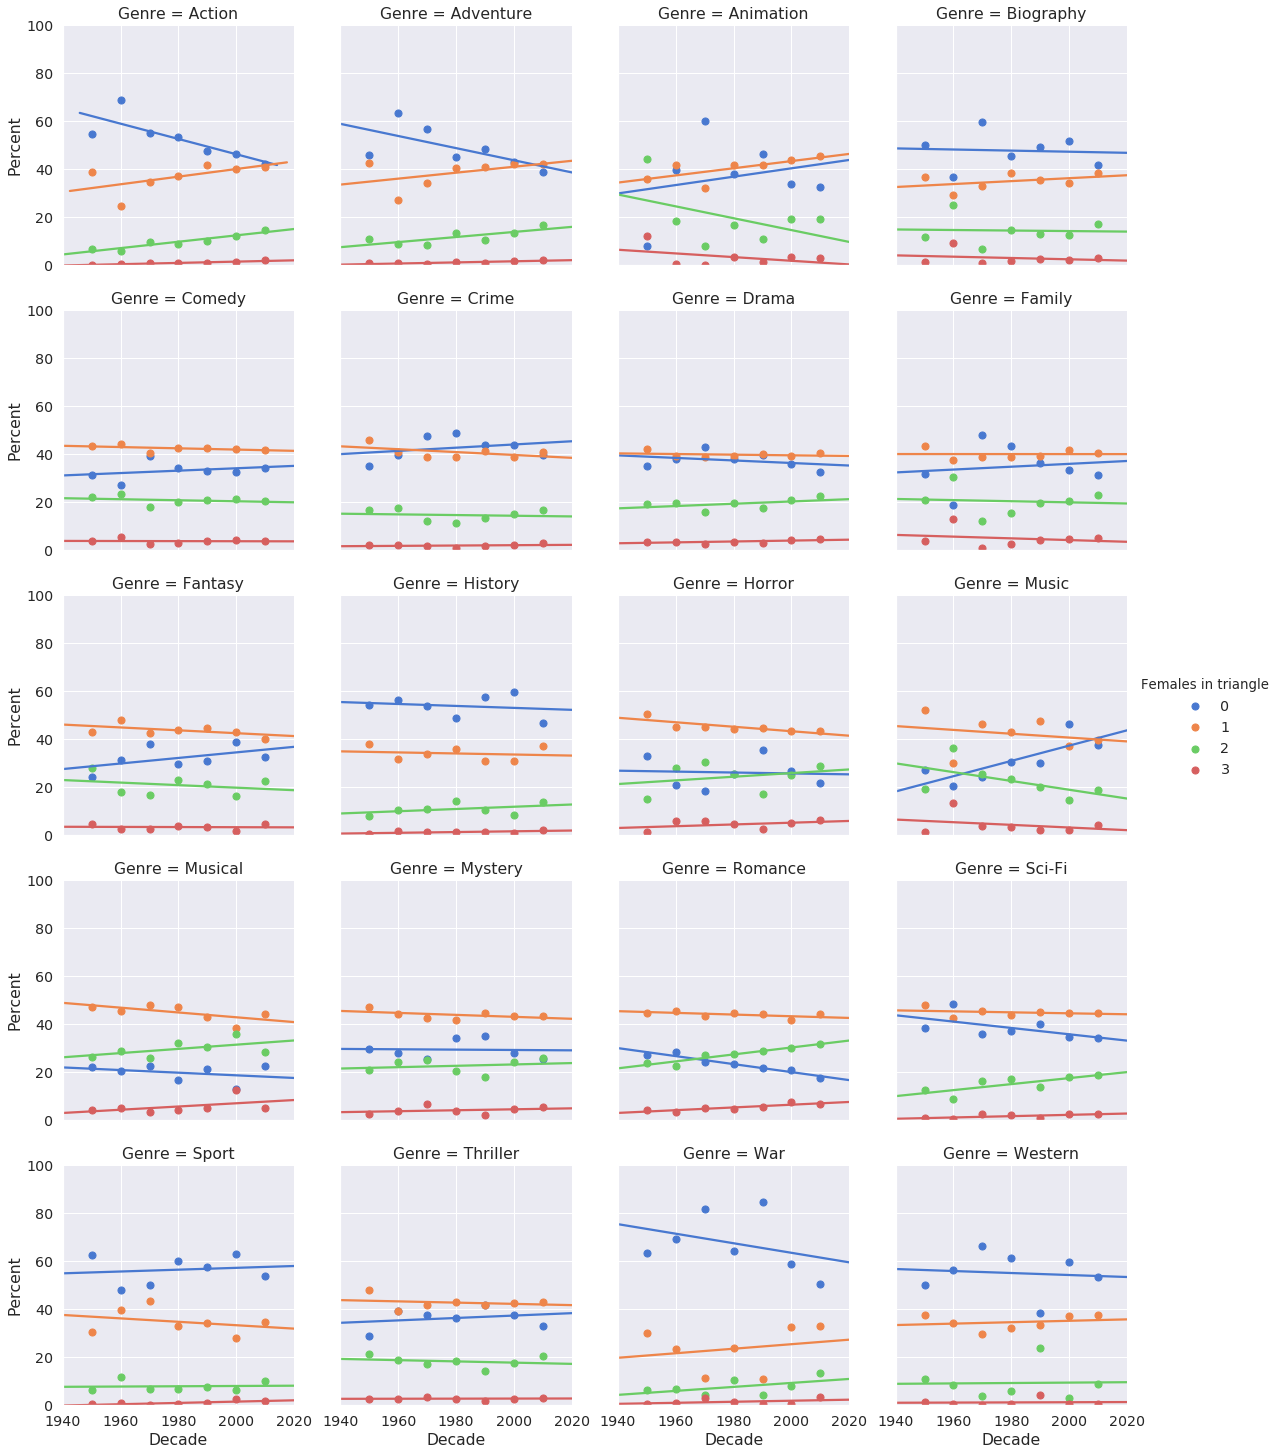

In [67]:
draw_genres = tri_genre_decade.groupby("Genre").count().query("Decade==28").index
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# Load the example dataset for Anscombe's quartet

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="Decade", y="Percent", col="Genre", hue="Females in triangle", data=tri_genre_decade[tri_genre_decade["Genre"].isin(draw_genres)],
           col_wrap=4, ci=None, palette="muted", height=4,legend_out=True,
           scatter_kws={"s": 50, "alpha": 1})
g.set(xlim=(1940, 2020), ylim=(0, 100))
g.fig.tight_layout(w_pad=1)
g.fig.subplots_adjust(top=1,right=0.88)


#### Centrality

In [213]:
from itertools import islice
gender_top_movies = islice(gender_in_top_movies(), 1000)

In [214]:
gender_top_movies = list(gender_top_movies)

  5%|▍         | 1252/27508 [00:03<00:46, 565.37it/s]


In [215]:
import itertools
gender_top_100 = list(itertools.chain.from_iterable(gender_top_movies[:100]))
gender_top_1000 = list(itertools.chain.from_iterable(gender_top_movies))

In [216]:
print(pd.DataFrame(gender_top_100)[0].value_counts())
print(pd.DataFrame(gender_top_1000)[0].value_counts())

M    569
F    174
U      3
Name: 0, dtype: int64
M    6015
F    2122
U      75
Name: 0, dtype: int64


In [261]:
from subs2graph.graph_analyzer import analyze_genders
analyze_genders()

100%|██████████| 18015/18015 [02:59<00:00, 100.16it/s]


In [ ]:
    p = "../temp/movies/"
    res = []
    json_path = os.path.join(p, "*", "json")
    for g_pth in tqdm(glob.glob(os.path.join(json_path, f"*roles.json"))):

        if g_pth:
            with open(g_pth) as f:
                g = json_graph.node_link_graph(json.load(f))
                if g.number_of_nodes() > 5:
                    d = get_node_features(g)
                    res += list(d)

In [269]:
p = "../temp/movies/"
res = []
json_path = os.path.join(p, "*", "json")
f_list = glob.glob(os.path.join(json_path, f"*roles.json"))


In [273]:
the_force = [film for film in f_list if "The Force" in film][0]

In [278]:
from networkx.readwrite import json_graph
import json
with open(the_force) as f:
    g = json_graph.node_link_graph(json.load(f))

In [298]:
from subs2graph.video_sn_analyzer import get_movies_by_title
get_movies_by_title("Star Wars", True)

ImportError: cannot import name 'get_movies_by_title'

In [288]:
with open('../temp/movies/Star Wars: The Force Awakens/json/(2015) - Star Wars: The Force Awakens.json') as f:
    f.readlines()

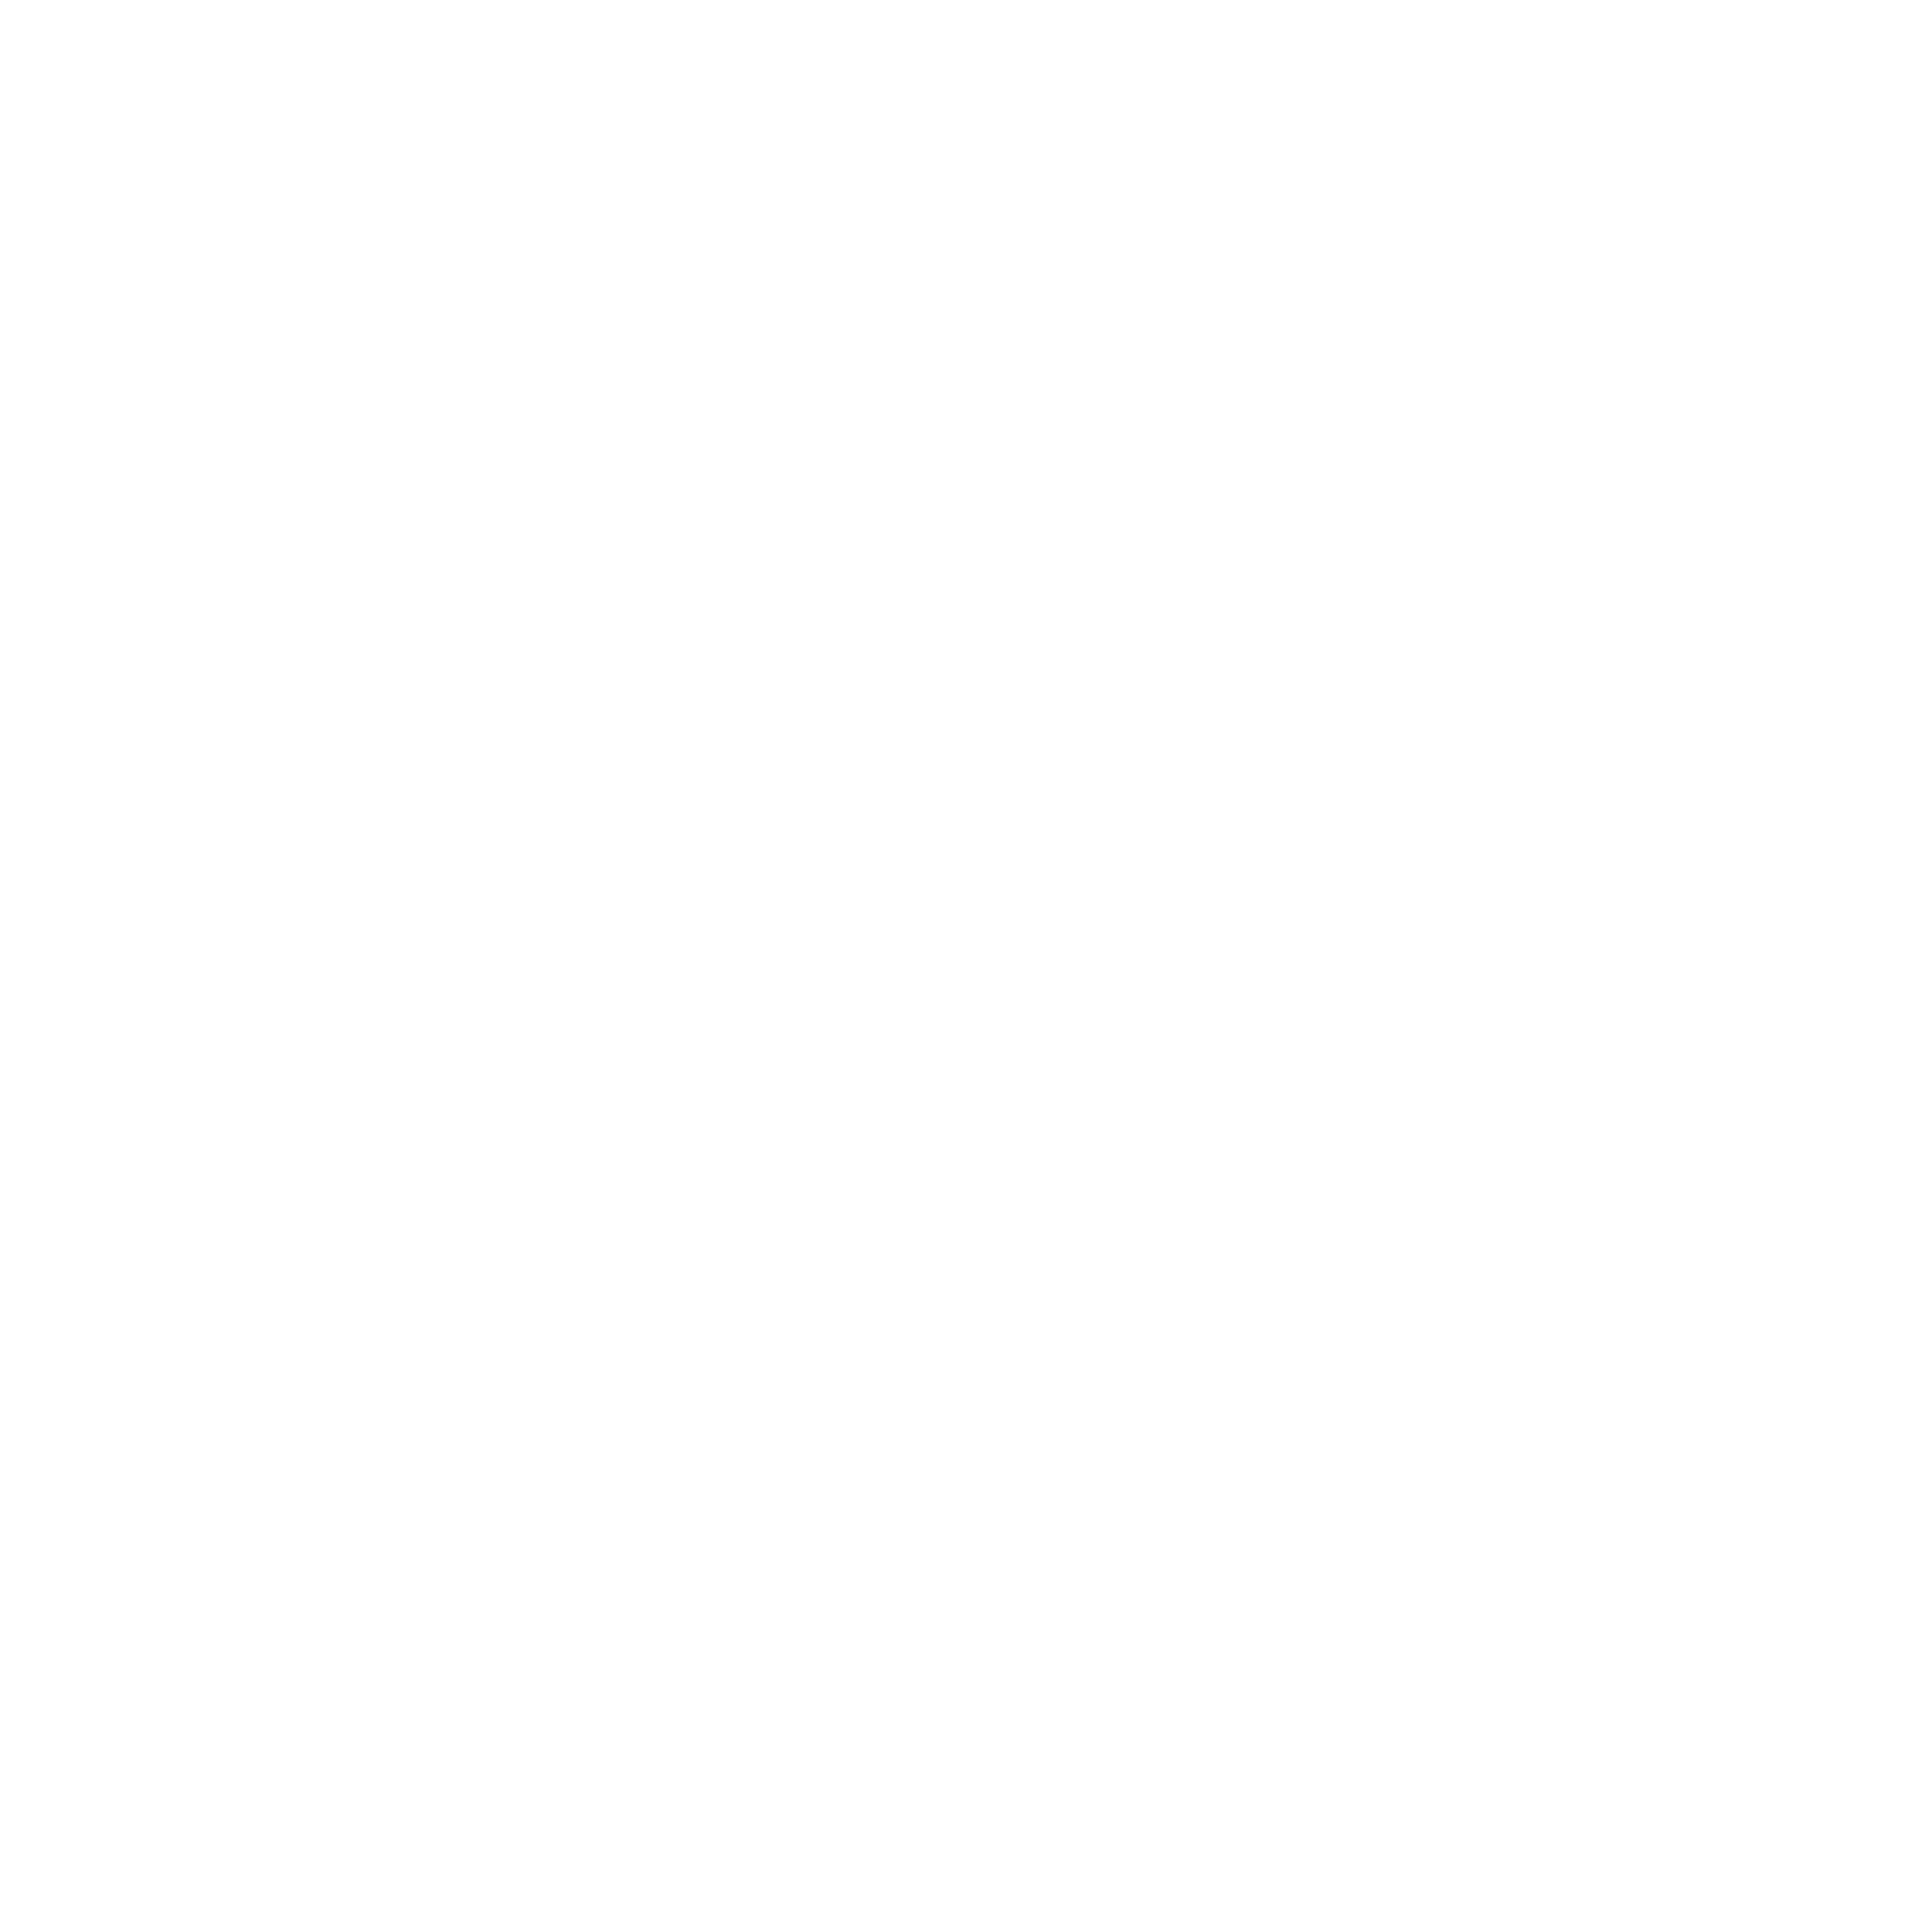

In [296]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "../temp/movies/Star Wars: The Force Awakens/graphs/(2015) - Star Wars: The Force Awakens.png"
Image(filename = PATH, width=100, height=100)


In [291]:
os.listdir('../temp/movies/Star Wars: The Force Awakens/graphs/')

NotADirectoryError: [Errno 20] Not a directory: '../temp/movies/Star Wars: The Force Awakens/graphs/(2015) - Star Wars: The Force Awakens.png'

In [263]:
gender_centrality = pd.read_csv("../temp/gender.csv", index_col=0)

In [262]:
len(gender_centrality)

168561

In [264]:
len(gender_centrality)

168561

In [9]:
gender_centrality["gender"].value_counts()

M    115099
F     53027
U       435
Name: gender, dtype: int64

In [80]:
def rank_by_centrality(gender_centrality, centrality_type):
    rank = pd.Series()
    gender_centrality = gender_centrality.copy()
    for g in gender_centrality.groupby("movie_name"):
        rank = rank.append(g[1][centrality_type].rank(ascending=False)).astype(int)
    gender_centrality[f"rank_{centrality_type}"] = rank
    gender_centrality = gender_centrality.fillna("U")
    return gender_centrality

In [90]:
def get_gender_distribution_by_rank(ranked_centrality, centrality_type):
    rank_centrality = pd.pivot_table(ranked_centrality[["gender",f"rank_{centrality_type}"]],index="gender", columns=f"rank_{centrality_type}", aggfunc=len).T
    rank_centrality["F%"]  = rank_centrality["F"] / (rank_centrality["F"] + rank_centrality["M"])
    rank_centrality["M%"]  = rank_centrality["M"] / (rank_centrality["F"] + rank_centrality["M"])
    return rank_centrality

In [315]:
def get_movies_with_topn_gender(rank_gender, centrality_type,n=10):
    rank_gender = rank_gender.copy()
    for gender in set().union(rank_gender.gender.values):
        rank_gender[gender] = rank_gender.apply(lambda _: int(gender in _.gender), axis=1)
    rank_gender = rank_gender.sort_values(["movie_name", f"rank_{centrality_type}"])
    rank_gender = rank_gender.groupby("movie_name").head(n)
    return rank_gender.groupby("movie_name").sum().sort_values(["M","imdb_rating"], ascending=False)

In [83]:
ranked_centrality = rank_by_centrality(gender_centrality, "degree_centrality")

In [93]:
rank_gender = get_gender_distribution_by_rank(ranked_centrality, "degree_centrality")

In [362]:
movies_with_top10_gender = get_movies_with_top10_gender(ranked_centrality, "degree_centrality")

In [316]:
movies_with_top3_gender = get_movies_with_topn_gender(ranked_centrality, "degree_centrality", n=3)

In [324]:
len(movies_with_top3_gender[(movies_with_top3_gender["year"]==2018) & (movies_with_top3_gender["F"]==3)])

12

In [338]:
gen_year = movies_with_top3_gender[(movies_with_top3_gender["year"]==1988)].sum()

In [339]:
gen_year["F"] / (gen_year["M"] + gen_year["F"])

0.32229580573951433

In [341]:
ovt = movies_with_top3_gender.groupby("year").sum()
ovt["F%"] = ovt["F"] / (ovt["M"] + ovt["F"])

In [363]:
movies_with_top10_gender = movies_with_top10_gender[movies_with_top10_gender["M"]+movies_with_top10_gender["F"]==10]

In [364]:
movies_with_top10_gender["year"] = movies_with_top10_gender["year"]/10

In [376]:
ovt2 = movies_with_top10_gender.groupby("year").sum()
ovt2["Top 10 Females"] = ovt2["F"] / (ovt2["M"] + ovt2["F"])

In [377]:
movies_with_top1_gender = get_movies_with_topn_gender(ranked_centrality, "degree_centrality", n=1)
ovt3 = movies_with_top1_gender.groupby("year").sum()
ovt3["Top 1 Female"] = ovt3["F"] / (ovt3["M"] + ovt3["F"])

In [380]:
ovt["Top 3 Females"] = ovt["F%"]

In [404]:
top_time= pd.concat([ovt3["Top 1 Female"], ovt["Top 3 Females"],ovt2["Top 10 Females"]], axis=1, sort=False)

Text(0, 0.5, 'Percentage of Female Actors')

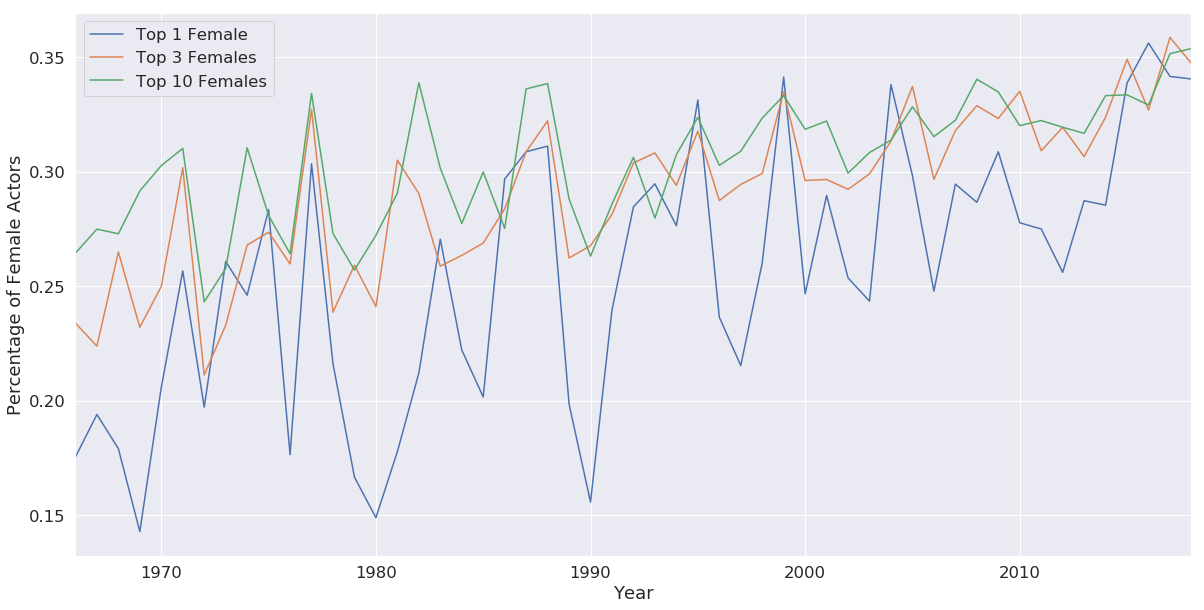

In [406]:
ax = top_time[top_time.index>1965].plot(figsize=(20,10))
ax.set_xlabel("Year")
ax.set_ylabel("Percentage of Female Actors")

Object `top_time[top_time.index>1965].plot` not found.


In [391]:
sea = top_time.reset_index()
sea["year"] = sea.index.values
# sea = sea[sea["year"] > 1950]
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.5) 

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lineplot(x="year", y=["Top 3 Females", "Top 10 Females", "Top 1 Female"], data=sea,
               palette=pal, y_jitter=.02)
# g.set(xlim=(0, 80), ylim=(-.05, 1.05))
g.fig.set_size_inches(10,10)
g.set(xlabel='Year', ylabel='Average Number of Females')


ValueError: could not broadcast input array from shape (94) into shape (3)

In [344]:
t = movies_with_top10_gender.groupby("movie_name").sum()

In [103]:
ranked_centrality[ranked_centrality["movie_name"]=="Avengers: Infinity War - roles"]

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,gender,imdb_rating,movie_name,name,pagerank,pr_weight,total_weight,year,rank_degree_centrality
10729,0.290299,0.112479,0.878788,0.286667,25,0.862069,M,8.6,Avengers: Infinity War - roles,Robert Downey Jr.,0.095949,0.174854,751,2018,1
10730,0.025969,0.027094,0.644444,0.551282,13,0.448276,M,8.6,Avengers: Infinity War - roles,Tom Holland,0.048557,0.068598,313,2018,5
10731,0.002743,0.041872,0.547170,0.714286,7,0.241379,M,8.6,Avengers: Infinity War - roles,Tom Vaughan-Lawlor,0.027543,0.013940,44,2018,15
10732,0.132382,0.054187,0.805556,0.376623,22,0.758621,M,8.6,Avengers: Infinity War - roles,Robert Pralgo,0.080771,0.141676,623,2018,2
10733,0.017114,0.085181,0.630435,0.621212,12,0.413793,M,8.6,Avengers: Infinity War - roles,Benedict Cumberbatch,0.045400,0.032571,126,2018,8
10734,0.028580,0.061782,0.674419,0.552381,15,0.517241,M,8.6,Avengers: Infinity War - roles,Chris Hemsworth,0.055109,0.052458,224,2018,4
10735,0.013297,0.056034,0.630435,0.696970,12,0.413793,M,8.6,Avengers: Infinity War - roles,Chris Pratt,0.044394,0.072986,340,2018,8
10736,0.207396,0.232964,0.743590,0.374269,19,0.655172,M,8.6,Avengers: Infinity War - roles,Mark Ruffalo,0.078256,0.078999,285,2018,3
10737,0.004367,0.084770,0.557692,0.714286,8,0.275862,F,8.6,Avengers: Infinity War - roles,Elizabeth Olsen,0.031471,0.019825,65,2018,12
10738,0.000000,0.004926,0.500000,1.000000,3,0.103448,M,8.6,Avengers: Infinity War - roles,Tom Hiddleston,0.014599,0.008195,16,2018,24


In [235]:
t.sort_values("M", ascending=False)

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,imdb_rating,pagerank,pr_weight,total_weight,year,rank_pagerank,rank_degree_centrality,F,M,U
movie_name,,,,,,,,,,,,,,,,
'71 - roles,1.628205,1.724359,4.779832,5.619048,42,3.230769,72.0,0.874324,0.888889,207,20140,53,53,0,10,0
Harry Potter and the Goblet of Fire - roles,0.628498,0.624095,7.411938,4.976770,247,6.333333,77.0,0.458404,0.603265,4485,20050,55,54,0,10,0
Heavy Weights - roles,0.638107,0.748413,7.267579,6.283142,128,6.095238,67.0,0.649644,0.761927,1589,19950,55,55,0,10,0
Hour of the Gun - roles,0.660539,0.974877,7.274999,7.027052,101,5.941176,67.0,0.770019,0.871428,1892,19670,55,53,0,10,0
How to Make Money Selling Drugs - roles,0.988095,1.437229,5.915989,6.016667,63,2.863636,77.0,0.707263,0.781611,1218,20120,55,53,0,10,0
How to Steal a Million - roles,0.583333,1.361111,6.992049,6.783333,48,5.333333,76.0,1.000000,1.000000,876,19660,55,53,0,10,0
Hunter Killer - roles,0.944337,0.998358,6.113999,4.917422,125,4.310345,70.0,0.574550,0.638766,924,20180,55,54,0,10,0
Hyena Road - roles,0.948718,1.397436,6.315974,7.176479,57,4.384615,65.0,0.888514,0.926761,711,20150,54,54,0,10,0
Hype! - roles,0.691667,0.783333,3.851924,4.953968,43,2.687500,77.0,0.797162,0.777095,221,19960,52,54,0,10,0


In [236]:
t["M"].value_counts()

7     1840
8     1686
6     1566
9     1069
5     1009
4      502
10     379
3      175
2       60
1        6
0        5
Name: M, dtype: int64

In [237]:
t["F"].value_counts()

3     1840
2     1686
4     1566
1     1069
5     1009
6      502
0      379
7      175
8       60
9        6
10       5
Name: F, dtype: int64

In [238]:
t["M"].value_counts() + t["F"].value_counts()

0      384
1     1075
2     1746
3     2015
4     2068
5     2018
6     2068
7     2015
8     1746
9     1075
10     384
dtype: int64

In [239]:
hist_df = pd.DataFrame()
hist_df["F"]= t["F"].value_counts() 
hist_df["M"]=t["M"].value_counts()

In [240]:
hist_df = hist_df.sort_index()

[1.3020833333333335, 0.5581395348837209, 3.436426116838488, 8.6848635235732, 24.274661508704064, 50.0, 75.72533849129593, 91.3151364764268, 96.56357388316151, 99.44186046511628, 98.69791666666666]
[98.69791666666666, 99.44186046511628, 96.56357388316151, 91.3151364764268, 75.72533849129593, 50.0, 24.274661508704064, 8.6848635235732, 3.436426116838488, 0.5581395348837209, 1.3020833333333335]


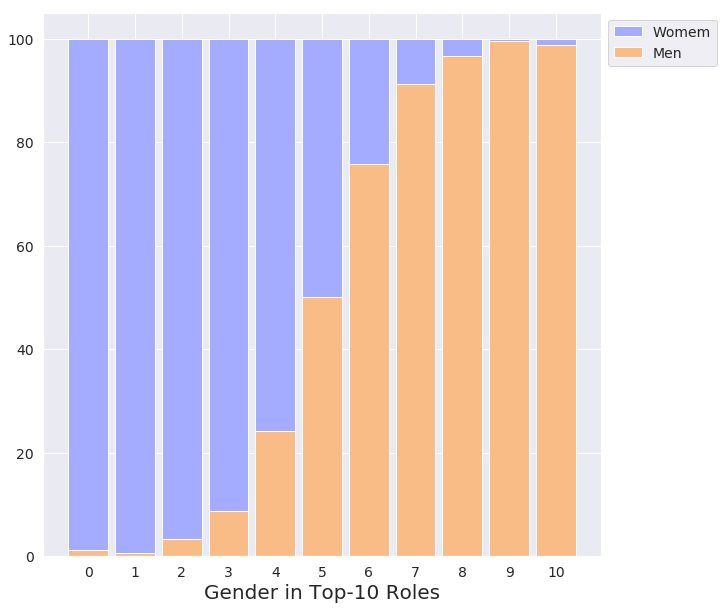

In [241]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
plt.figure(figsize=(10,10)) 

# Data
r = [0,1,2,3,4,5,6,7,8,9,10]
raw_data = {'male': hist_df["M"],'female': hist_df["F"]}
df = pd.DataFrame(raw_data)

# From raw value to percentage
totals = [i+j for i,j in zip(df['male'], df['female'])]
mBars = [i / j * 100 for i,j in zip(df['male'], totals)]
fBars = [i / j * 100 for i,j in zip(df['female'], totals)]
print(mBars)
print(fBars)

# plot
barWidth = 0.85
names = [0,1,2,3,4,5,6,7,8,9,10]
# Create green Bars
# Create orange Bars
plt.bar(r, fBars, bottom=mBars, color='#a3acff', edgecolor='white', width=barWidth, label="Womem")


plt.bar(r, mBars, bottom=0, color='#f9bc86', edgecolor='white', width=barWidth, label="Men")

# Create blue Bars

# Custom x axis
plt.xticks(r, names, size=14)
plt.yticks(size=14)

plt.xlabel("Gender in Top-10 Roles", size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':14})

# Show graphic
plt.show()


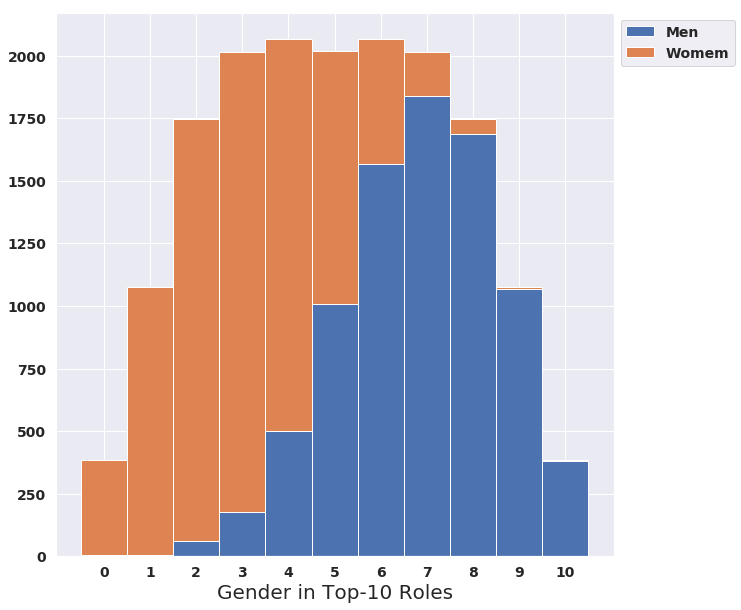

In [242]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
plt.figure(figsize=(10,10)) 

# y-axis in bold
rc('font', weight='bold')

# Values of each group
bars1 = hist_df["M"]
bars2 = hist_df["F"]
bars3 = [25, 3, 23, 25, 17]

# Heights of bars1 + bars2 (TO DO better)
bars = hist_df["M"] + hist_df["F"]

# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6,7,8,9,10]

# Names of group and bar width
names = [0,1,2,3,4,5,6,7,8,9,10]
barWidth = 1

# Create brown bars
plt.bar(r, bars1,  edgecolor='white', width=barWidth, label="Men")
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1,  edgecolor='white', width=barWidth, label="Womem")
# Create green bars (top)
# plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(r, names, fontweight='bold', size=14)
plt.yticks(size=14)

plt.xlabel("Gender in Top-10 Roles", size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':14})

# Show graphic
plt.show()


Text(0.5, 0, 'Women in Top-10 Roles')

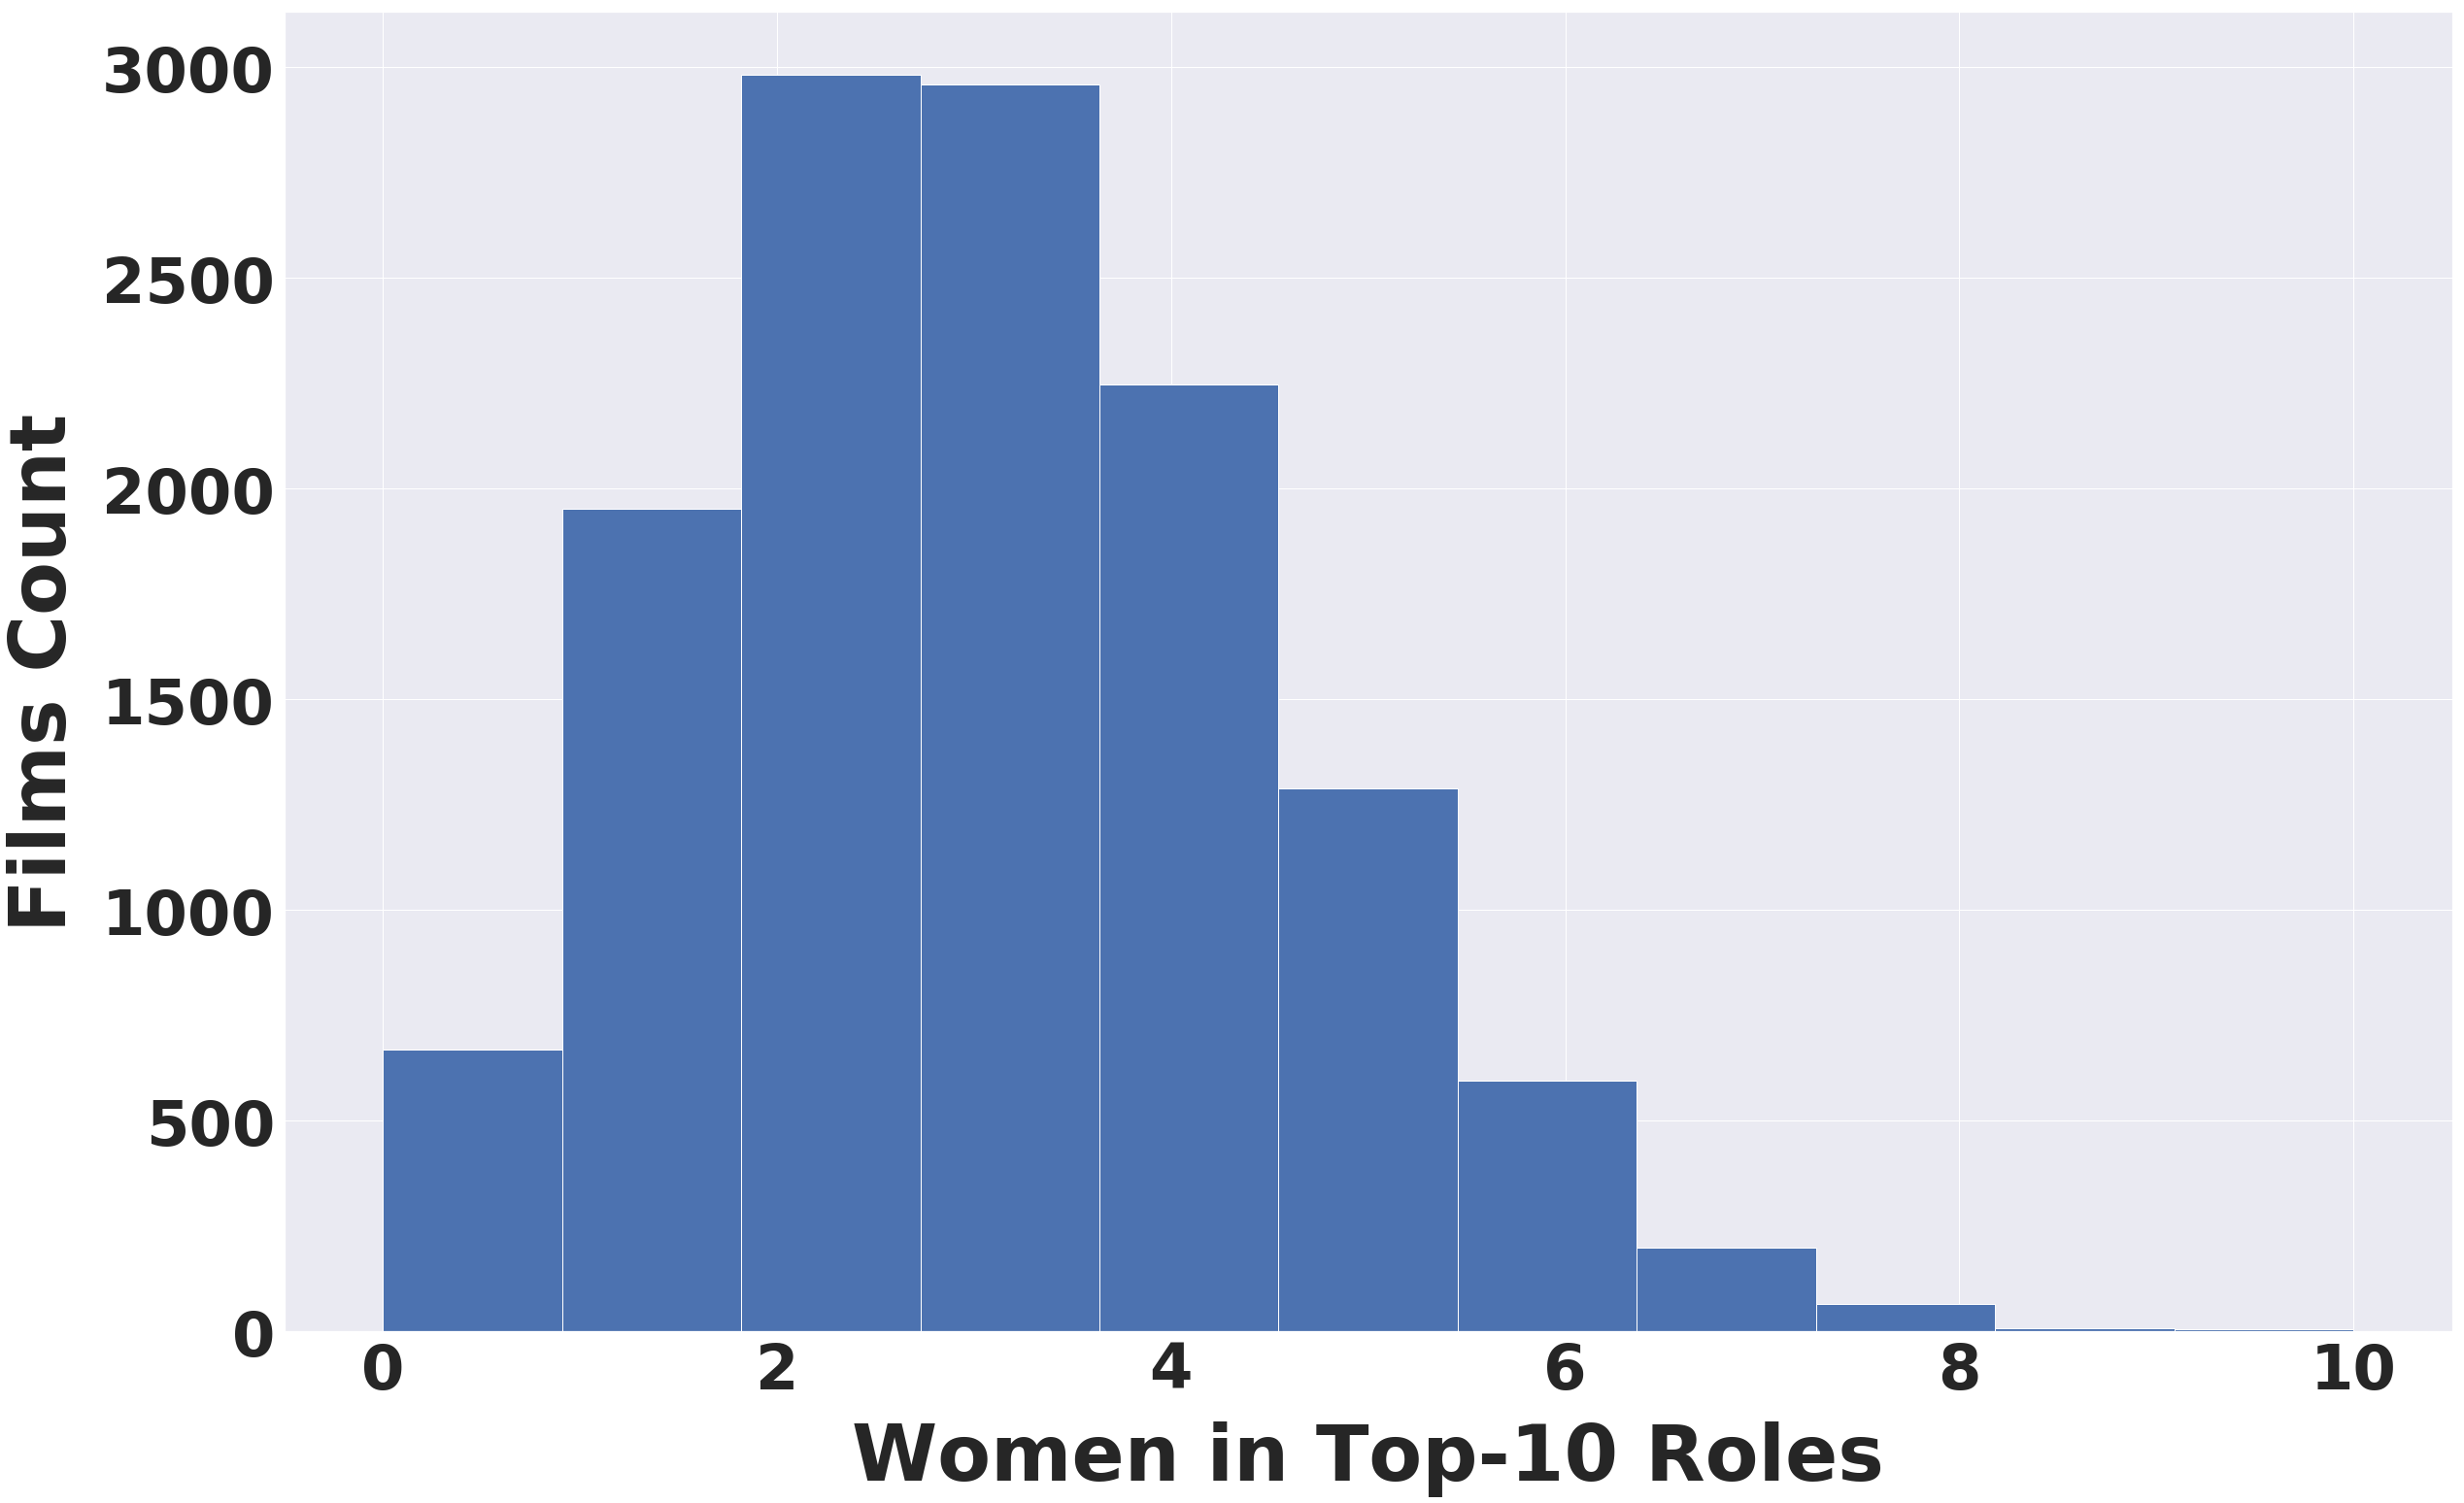

In [243]:
x = pager_gcentrality.groupby("movie_name").sum()["F"].hist(bins=11,figsize=(40, 25), ylabelsize=64, xlabelsize=64)

# Set x-axis label
x.set_ylabel("Films Count", labelpad=20, weight='bold', size=80)

# Set y-axis label
x.set_xlabel("Women in Top-10 Roles", labelpad=20, weight='bold', size=80)

Text(0.5, 0, 'Men in Top-10 Roles')

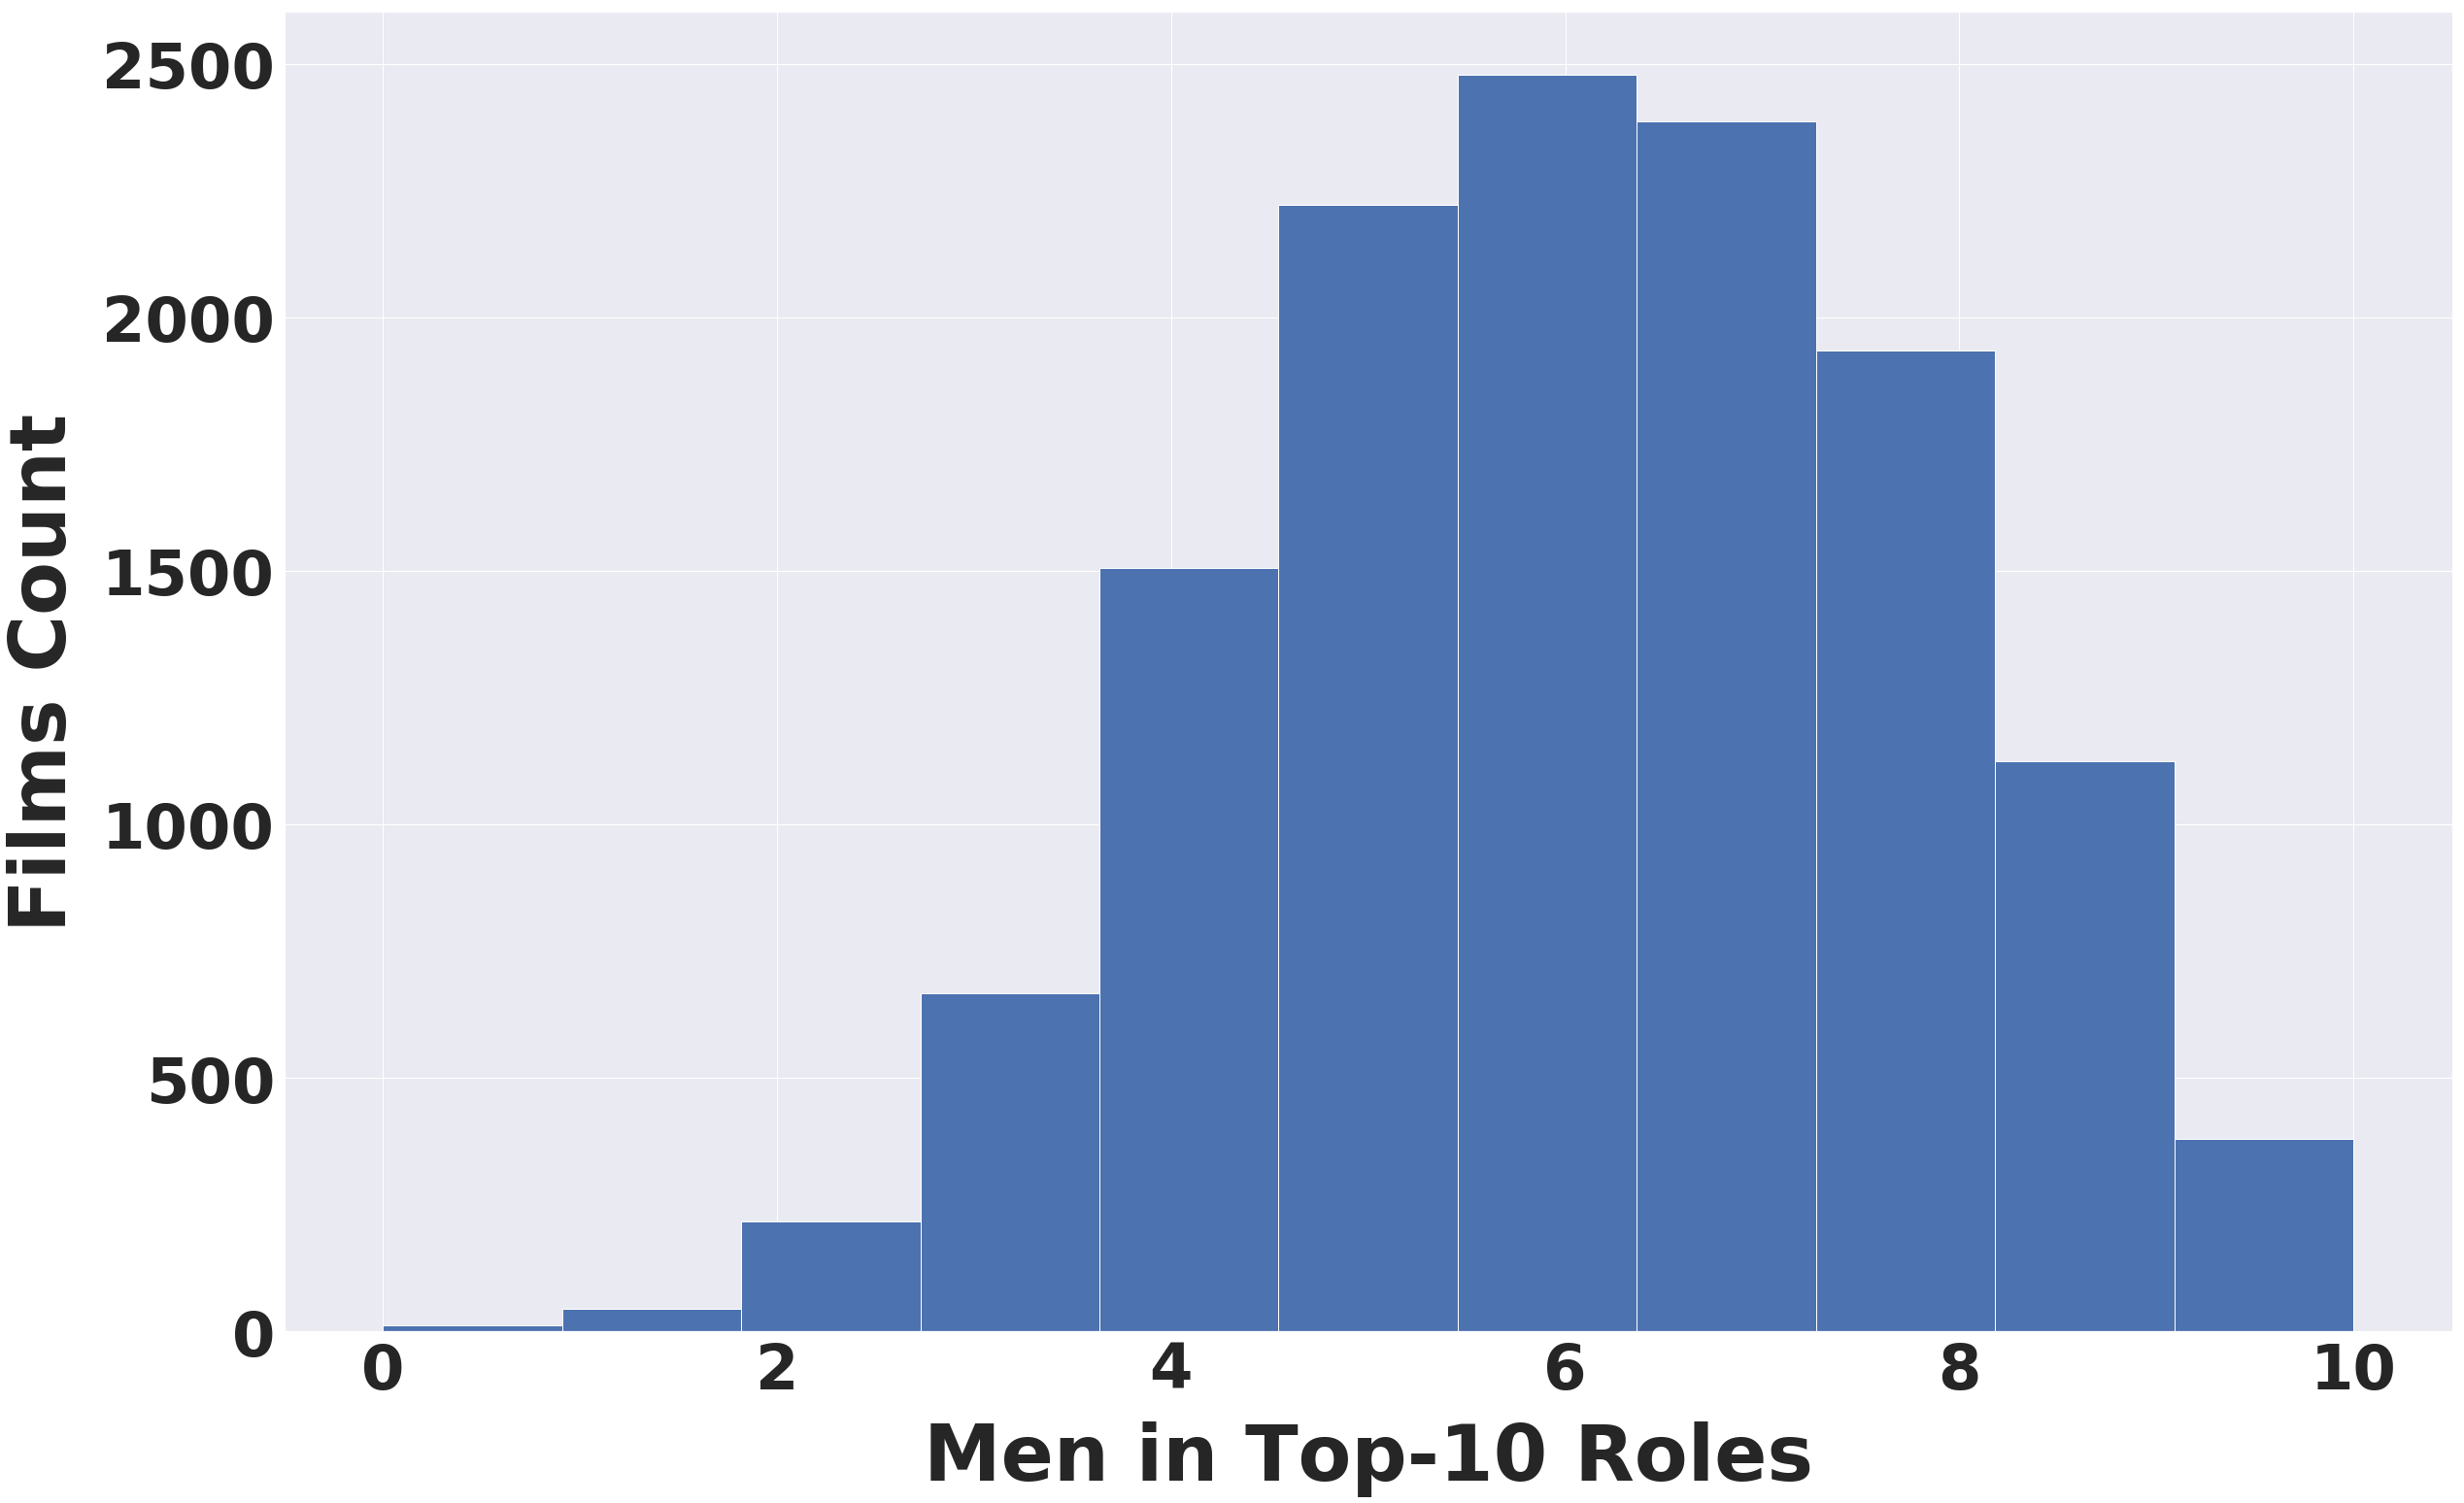

In [244]:
x = pager_gcentrality.groupby("movie_name").sum()["M"].hist(bins=11,figsize=(40, 25),ylabelsize=64, xlabelsize=64)
# Set x-axis label
x.set_ylabel("Films Count", labelpad=20, weight='bold', size=80)

# Set y-axis label
x.set_xlabel("Men in Top-10 Roles", labelpad=20, weight='bold', size=80)

In [361]:
m = pager_gcentrality.groupby("movie_name").sum()["M"].value_counts()

NameError: name 'pager_gcentrality' is not defined

In [246]:
f = pager_gcentrality.groupby("movie_name").sum()["F"].value_counts()

In [247]:
f_overtime_temp = pager_gcentrality.groupby("movie_name").agg(['sum','count'])

In [248]:
f_overtime = pd.DataFrame()
f_overtime["F"] = f_overtime_temp["F"]["sum"]
f_overtime["year"] = f_overtime_temp["year"]["sum"]/f_overtime_temp["year"]["count"]

In [249]:
f_overtime[f_overtime["year"]==2018]["F"].describe()

count    230.000000
mean       3.365217
std        1.557237
min        0.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: F, dtype: float64

In [210]:
f_overtime.groupby("year").agg(["count","mean"]).tail(60)

NameError: name 'f_overtime' is not defined

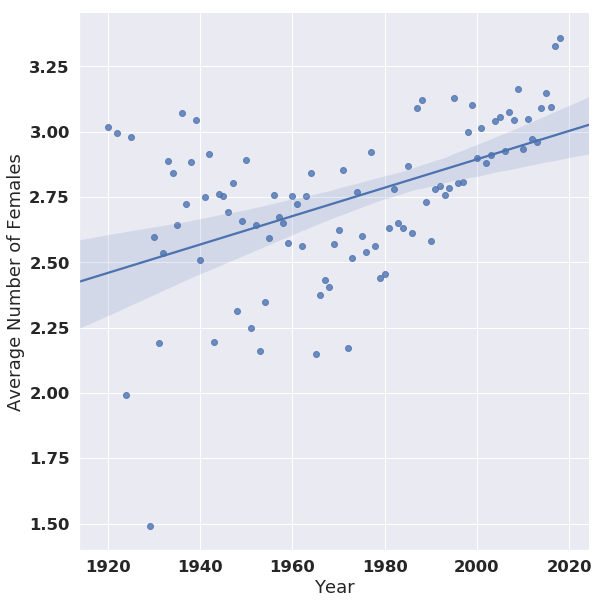

In [106]:
sea = f_overtime[["year", "F"]].groupby("year").mean()
sea["year"] = sea.index.values
# sea = sea[sea["year"] > 1950]
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.5) 

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="year", y="F", data=sea[["year","F"]],
               palette=pal, y_jitter=.02)
# g.set(xlim=(0, 80), ylim=(-.05, 1.05))
g.fig.set_size_inches(10,10)
g.set(xlabel='Year', ylabel='Average Number of Females')


#### Closeness

In [104]:
ranked_closeness = rank_by_centrality(gender_centrality, "closeness")
rank_gender_closeness = get_gender_distribution_by_rank(ranked_closeness, "closeness")

In [253]:
for folder in os.listdir("../temp/movies/"):
    if "The Force Awakens" in folder:
        print(folder)
        break

Star Wars: The Force Awakens


In [257]:
os.listdir("../temp/movies/Star Wars: The Force Awakens")

['csv',
 'json',
 'graphs',
 'subtitles',
 '(2015) - Star Wars: The Force Awakens.json']

In [267]:
set(gender_centrality.loc[gender_centrality.movie_name.str.contains("Star Wars")]["movie_name"])

{'Rogue One: A Star Wars Story - roles',
 'Solo: A Star Wars Story - roles',
 'Star Wars: Episode I - The Phantom Menace - roles',
 'Star Wars: Episode II - Attack of the Clones - roles',
 'Star Wars: Episode III - Revenge of the Sith - roles',
 'Star Wars: Episode IV - A New Hope - roles',
 'Star Wars: Episode V - The Empire Strikes Back - roles',
 'Star Wars: Episode VI - Return of the Jedi - roles',
 'Star Wars: The Last Jedi - roles'}

In [188]:
c1 =[]
c2 = []
for movie in gender_centrality.groupby(["movie_name"]):
    f = movie[1][movie[1]["gender"]=="F"]
    m = movie[1][movie[1]["gender"]=="M"]
    c_diff = f["degree"].sum() / m["degree"].sum()
    if 0.8<c_diff <1.2:
        c1.append((movie[0], c_diff))
    else:
        c2.append((movie[0], c_diff))

/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  


In [189]:
len(c1), len(c2)

(1545, 11424)

In [231]:
[t for t in c2 if "The Force Awakens" in t[0]]

[]

In [230]:
[t for t in c1 if "The Force Awakens" in t[0]]

[]

In [190]:
len(c1)/(len(c1) +len(c2))

0.11913023363405043

In [186]:
d = pd.DataFrame(c2)
len(d[d[1]<0.5])

7239

#### Data Downloading

In [485]:
import requests

r = requests.get("http://bechdeltest.com/api/v1/getAllMovies")

In [489]:
bechdel = r.json()

In [496]:
bechdel_df = pd.DataFrame(bechdel)

#### ML

In [410]:
from subs2graph.bechdel_classifier import BechdelClassifier

In [411]:
from turicreate import SFrame

In [29]:
graph_features = SFrame.read_csv(f"{TEMP_PATH}/graph_features.csv")

Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 100 lines in 0.064193 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,int,float,int,str,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 16303 lines in 0.078814 secs.

In [37]:
graph_features = imdb_data.title.filter_by("movie", "titleType").join(graph_features,
                                                                                   on={"primaryTitle": "movie_name",
                                                                                       "startYear": "year"})

In [115]:
graph_features[graph_features["primaryTitle"]=="Shin Godzilla"]

Columns:
	tconst	str
	titleType	str
	primaryTitle	str
	originalTitle	str
	isAdult	int
	startYear	int
	endYear	str
	runtimeMinutes	int
	genres	str
	appearance-25%	float
	appearance-50%	float
	appearance-75%	float
	appearance-max	float
	appearance-mean	float
	appearance-min	float
	appearance-std	float
	average_clustering	float
	average_weighted_clustering	float
	betweenness-25%	float
	betweenness-50%	float
	betweenness-75%	float
	betweenness-max	float
	betweenness-mean	float
	betweenness-min	float
	betweenness-std	float
	clique_number	int
	closeness-25%	float
	closeness-50%	float
	closeness-75%	float
	closeness-max	float
	closeness-mean	float
	closeness-min	float
	closeness-std	float
	degree-25%	float
	degree-50%	float
	degree-75%	float
	degree-max	float
	degree-mean	float
	degree-min	float
	degree-std	float
	edge_number	int
	f_count	int
	imdb_rating	float
	m_count	int
	node_number	int
	pagerank-25%	float
	pagerank-50%	float
	pagerank-75%	float
	pagerank-max	float
	pagerank-mean	float
	pagerank-min	float
	pagerank-std	float
	weight-25%	float
	weight-50%	float
	weight-75%	float
	weight-max	float
	weight-mean	float
	weight-min	float
	weight-std	float
	weighted_betweenness-25%	float
	weighted_betweenness-50%	float
	weighted_betweenness-75%	float
	weighted_betweenness-max	float
	weighted_betweenness-mean	float
	weighted_betweenness-min	float
	weighted_betweenness-std	float
	weighted_pagerank-25%	float
	weighted_pagerank-50%	float
	weighted_pagerank-75%	float
	weighted_pagerank-max	float
	weighted_pagerank-mean	float
	weighted_pagerank-min	float
	weighted_pagerank-std	float

Rows: Unknown

Data:
+-----------+-----------+---------------+---------------+---------+-----------+
|   tconst  | titleType |  primaryTitle | originalTitle | isAdult | startYear |
+-----------+-----------+---------------+---------------+---------+-----------+
| tt4262980 |   movie   | Shin Godzilla |  Shin Gojira  |    0    |    2016   |
+-----------+-----------+---------------+---------------+---------+-----------+
+---------+----------------+------------------------+----------------+----------------+
| endYear | runtimeMinutes |         genres         | appearance-25% | appearance-50% |
+---------+----------------+------------------------+----------------+----------------+
|   None  |      120       | Action,Adventure,Drama |      5.0       |      13.0      |
+---------+----------------+------------------------+----------------+----------------+
+----------------+----------------+--------------------+----------------+
| appearance-75% | appearance-max |  appearance-mean   | appearance-min |
+----------------+----------------+--------------------+----------------+
|      24.0      |      65.0      | 18.285714285714285 |      3.0       |
+----------------+----------------+--------------------+----------------+
+--------------------+--------------------+-----------------------------+-----------------+
|   appearance-std   | average_clustering | average_weighted_clustering | betweenness-25% |
+--------------------+--------------------+-----------------------------+-----------------+
| 17.170156834294954 | 0.432396175253318  |     0.17233520866646873     |       0.0       |
+--------------------+--------------------+-----------------------------+-----------------+
+-----------------------+-----+
|    betweenness-50%    | ... |
+-----------------------+-----+
| 0.0017543859649122803 | ... |
+-----------------------+-----+
[? rows x 73 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [ ]:
graph_features["year"].min()

In [117]:
b.bechdel[b.bechdel["title"]=="Shin Godzilla"]

X1,id,imdbid,rating,title,year,tconst
7484,7196,4262980,1,Shin Godzilla,2016,tt4262980


In [211]:
s_wars = b.bechdel_imdb[b.bechdel_imdb["primaryTitle"].apply(lambda x: 1 if "star wars" in x.lower() else 0)]

In [216]:
s_wars[s_wars["titleType"]=="movie"].sort("startYear")

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear
tt0076759,movie,Star Wars: Episode IV - ANew Hope ...,Star Wars,0,1977,None
tt0080684,movie,Star Wars: Episode V -The Empire Strikes Back ...,Star Wars: Episode V -The Empire Strikes Back ...,0,1980,None
tt0086190,movie,Star Wars: Episode VI -Return of the Jedi ...,Star Wars: Episode VI -Return of the Jedi ...,0,1983,None
tt0120915,movie,Star Wars: Episode I -The Phantom Menace ...,Star Wars: Episode I -The Phantom Menace ...,0,1999,None
tt0121765,movie,Star Wars: Episode II -Attack of the Clones ...,Star Wars: Episode II -Attack of the Clones ...,0,2002,None
tt0121766,movie,Star Wars: Episode III -Revenge of the Sith ...,Star Wars: Episode III -Revenge of the Sith ...,0,2005,None
tt2488496,movie,Star Wars: The ForceAwakens ...,Star Wars: Episode VII -The Force Awakens ...,0,2015,None
tt3748528,movie,Rogue One: A Star WarsStory ...,Rogue One,0,2016,None
tt2527336,movie,Star Wars: The Last Jedi,Star Wars: Episode VIII -The Last Jedi ...,0,2017,None
tt3778644,movie,Solo: A Star Wars Story,Solo: A Star Wars Story,0,2018,None


In [412]:
b = BechdelClassifier()
b.build_dataset()
print(b.train_test())
rfc = b.train()
# v = rfc.predict_proba(b.val)[:, 1]
# print(v.mean())

Finished parsing file /storage/homedir/dima/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 100 lines in 0.040978 secs.

These column type hints were not used: X1

Finished parsing file /storage/homedir/dima/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 7871 lines in 0.026344 secs.

Finished parsing file /storage/homedir/dima/Projects/subs2graph/data/bechdel_features.csv

Parsing completed. Parsed 100 lines in 0.029291 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,int,float,int,float,float,float,float,float,float,float,float,int,float,int,float,float,float,float,float,float,float,float,float,float,int,float,int,float,int,int,float,int,str,int,float,float,float,float,float,float,float,float,float,float,int,float,int,float,float,float,float,float,float,int,float,float,float,float,float,float,float,float,int,float,int,int,int,int,int,float,float,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/subs2graph/data/bechdel_features.csv

Parsing completed. Parsed 12452 lines in 0.067411 secs.

F1:
0.7316465401571786
0.755
1.0
[0.65248227 0.81081081]
Recall:
[0.63535912 0.82288401]
Precision:
[0.67055394 0.79908676]
0.807738270493081


In [15]:
b.bechdel[b.bechdel["year"]<1986].to_dataframe()["rating"].value_counts()

3    812
1    411
0    327
2    246
Name: rating, dtype: int64

In [21]:
812 /(812+411+327+246)

0.4521158129175947

In [41]:
rfc = b.train()
# v = rfc.predict_proba(b.val)[:, 1]
# print(v.mean())

In [42]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index=b.X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
1%,0.186424
0%,0.142697
F_top10,0.138105
3%,0.135715
0,0.066394
1,0.047287
f_count,0.039692
2%,0.023926
3,0.020041
2,0.007337


In [43]:
bechdel_ml = b.bechdel_imdb
bechdel_ml = bechdel_ml[bechdel_ml["genres"] != None]
bechdel_ml = bechdel_ml.to_dataframe()
bechdel_ml["genres"] = bechdel_ml.genres.str.split(",")
for genre in set().union(*bechdel_ml.genres.values):
    bechdel_ml[genre] = bechdel_ml.apply(lambda _: int(genre in _.genres), axis=1)

In [58]:
bechdel_ml["rating"] = bechdel_ml["rating"] == 3

In [59]:
bechdel_ml

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,X1,...,Music,Crime,Romance,Family,Comedy,Adventure,Film-Noir,Fantasy,Short,Musical
0,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,None,4.0,"[Animation, Comedy, Romance]",1,...,0,0,1,0,1,0,0,0,0,0
1,tt0000012,short,The Arrival of a Train,L'arrivée d'un train à La Ciotat,0,1896.0,None,1.0,"[Documentary, Short]",4,...,0,0,0,0,0,0,0,0,1,0
2,tt0000014,short,Tables Turned on the Gardener,L'arroseur arrosé,0,1895.0,None,1.0,"[Comedy, Short]",2,...,0,0,0,0,1,0,0,0,1,0
3,tt0000091,short,The House of the Devil,Le manoir du diable,0,1896.0,None,3.0,"[Horror, Short]",7,...,0,0,0,0,0,0,0,0,1,0
4,tt0000131,short,A Terrible Night,Une nuit terrible,0,1896.0,None,1.0,"[Comedy, Horror, Short]",5,...,0,0,0,0,1,0,0,0,1,0
5,tt0000211,short,A Trip to the Moon,La lune à un mètre,0,1898.0,None,3.0,"[Comedy, Fantasy, Horror]",9,...,0,0,0,0,1,0,0,1,0,0
6,tt0000230,short,Cinderella,Cendrillon,0,1899.0,None,6.0,"[Drama, Fantasy, Short]",12,...,0,0,0,0,0,0,0,1,1,0
7,tt0000246,short,A Turn of the Century Illusionist,L'impressionniste fin de siècle,0,1899.0,None,1.0,[Short],11,...,0,0,0,0,0,0,0,0,1,0
8,tt0000272,short,As Seen Through a Telescope,As Seen Through a Telescope,0,1900.0,None,1.0,"[Comedy, Short]",13,...,0,0,0,0,1,0,0,0,1,0
9,tt0000300,short,The Enchanted Drawing,The Enchanted Drawing,0,1900.0,None,2.0,"[Animation, Comedy, Fantasy]",21,...,0,0,0,0,1,0,0,1,0,0


In [60]:
d = bechdel_ml.melt(["tconst","rating"],value_vars=genres).groupby(["rating", "variable"]).sum().reset_index().pivot(index='variable', columns='rating').reset_index()

In [66]:
clean_b = d.reset_index(level=None)["value"]
clean_b["genre"] = d["variable"]

In [67]:
clean_b["total"] = clean_b[True] + clean_b[False]

In [68]:
clean_b[True] = 100*clean_b[True]/clean_b["total"]

In [69]:
clean_b = clean_b.sort_values(True)

In [70]:
clean_b = clean_b.rename(columns={True:"%", "genre":"Genre"})

In [71]:
clean_b["total"] = 100

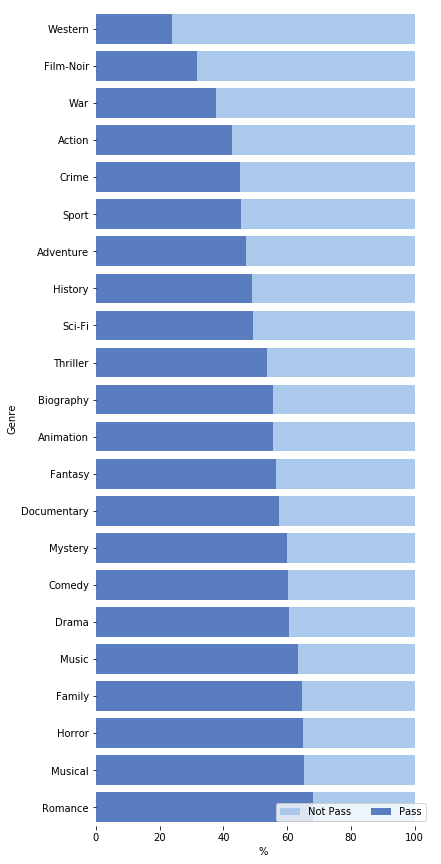

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(y="Genre", x="total", data=clean_b,
            label="Not Pass", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y="Genre", x="%", data=clean_b,
            label="Pass", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#        xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
sns.set(font_scale=1.5)


In [417]:
genres = {'Action',
          'Adventure',
          'Animation',
          'Biography',
          'Comedy',
          'Crime',
          'Documentary',
          'Drama',
          'Family',
          'Fantasy',
          'Film-Noir',
          'History',
          'Horror',
          'Music',
          'Musical',
          'Mystery',
          'Romance',
          'Sci-Fi',
          'Sport',
          'Thriller',
          'War',
          'Western'}

In [455]:
b.val["decade"] = b.val["startYear"] // 10
b.val["decade"] = b.val["decade"] * 10

res_all = []
for y, d in b.val.groupby("decade"):
    if len(d) > 10 and y>1920:
        d.pop("decade")
        v = rfc.predict_proba(d)[:, 1]
        print(y, v.mean(), len(d))
        res_all.append({"Decade": y, "Average Probability":v.mean()})

res = []
for g in genres:
#     print(f"{g}:")
    x = b.val.iloc[b.val[g].nonzero()]
    x = x[x["decade"] >1920]
    for y, d in x.groupby("decade"):
        if len(d) > 10:
            d.pop("decade")
            v = rfc.predict_proba(d)[:, 1]
#             print(y, v.mean(), len(d))
            res.append({"Genre":g, "Decade": y, "Average Probability":v.mean()})

1930 0.5370837731245885 150
1940 0.5040600034251007 304
1950 0.4854549612721567 392
1960 0.4946090689155617 412
1970 0.492770321612844 474
1980 0.5135549527467453 718
1990 0.5293086887952905 1020
2000 0.546526855240717 1967
2010 0.5555976082359262 2513


/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  from ipykernel import kernelapp as app
/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  from ipykernel import kernelapp as app
/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  from ipykernel import kernelapp as app
/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.U

In [437]:
res_all

[{'Decade': 1960, 'Average Probability': 0.49460906891556167},
 {'Decade': 1970, 'Average Probability': 0.492770321612844},
 {'Decade': 1980, 'Average Probability': 0.5135549527467453},
 {'Decade': 1990, 'Average Probability': 0.5293086887952905},
 {'Decade': 2000, 'Average Probability': 0.546526855240717},
 {'Decade': 2010, 'Average Probability': 0.5555976082359262}]

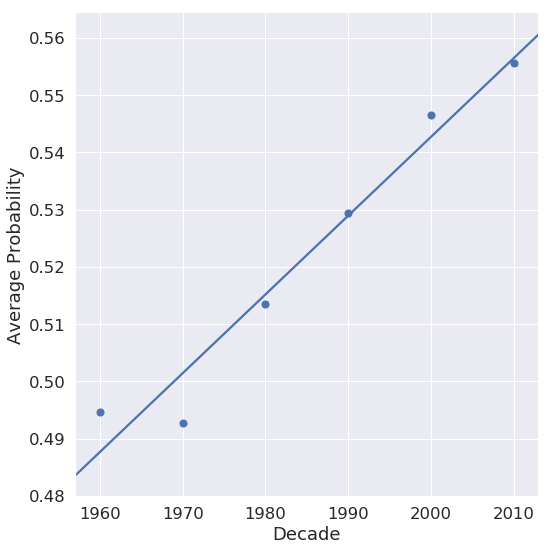

In [454]:
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
sns.lmplot(x="Decade", y="Average Probability", data=pd.DataFrame(res_all),
           ci=None, palette="muted", height=8,aspect=1,
           scatter_kws={"s": 50, "alpha": 1})


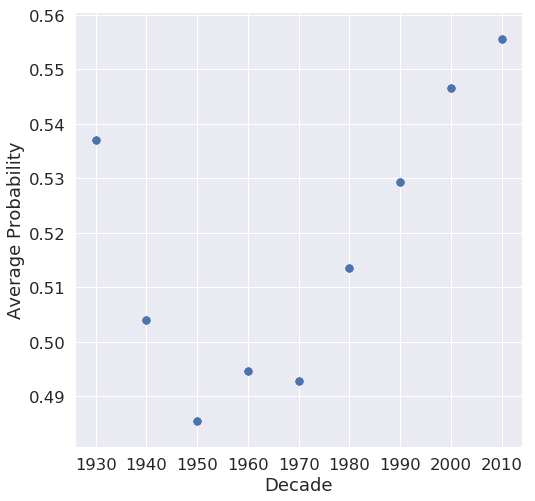

In [459]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set(font_scale=1.5)
sns.scatterplot(x="Decade", y="Average Probability", data=pd.DataFrame(res_all),
           ci=None, palette="muted",s =90)

In [429]:
df = pd.DataFrame(res)
df = df.sort_values("Genre")

In [430]:
draw_genres = df.groupby("Genre").count().query("Decade==7").index

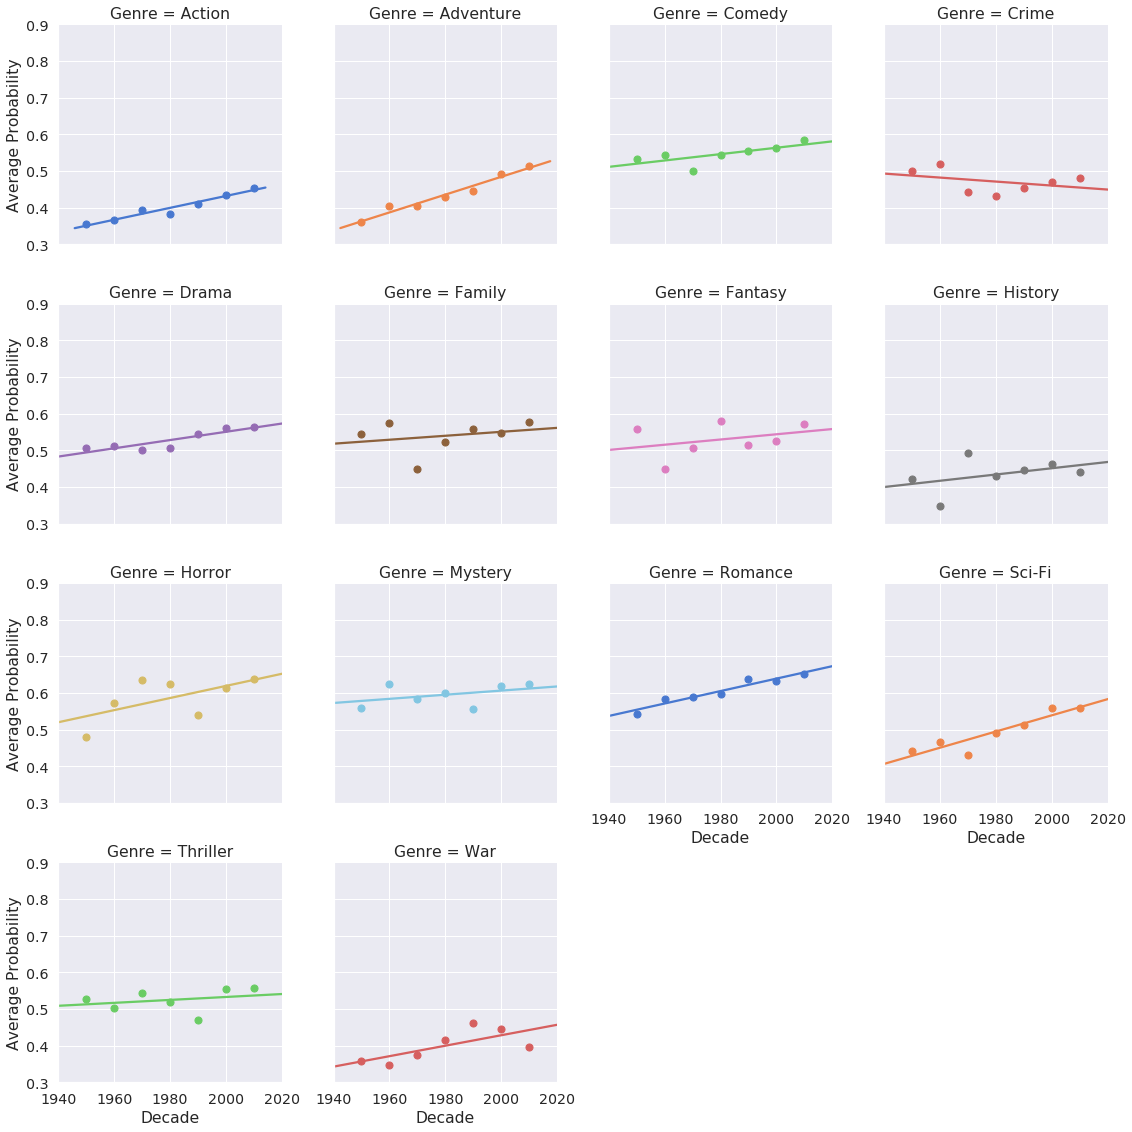

In [431]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# Load the example dataset for Anscombe's quartet

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="Decade", y="Average Probability", col="Genre", hue="Genre", data=df[df["Genre"].isin(draw_genres)],
           col_wrap=4, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.set(xlim=(1940, 2020), ylim=(0.3, 0.9))
g.fig.tight_layout(w_pad=1)


In [1713]:
from turicreate import SFrame

In [1714]:
bechdel = SFrame.read_csv("../data/bechdel.csv", column_type_hints={"imdbid": str})

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 100 lines in 0.05764 secs.

These column type hints were not used: X1

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 7871 lines in 0.037294 secs.

In [1715]:
bechdel.sort("year", False)

X1,id,imdbid,rating,title,year
7870,8423,0365545,3,Nappily Ever Aftet,2018
7869,8414,3829266,1,"Predator, The",2018
7868,8397,7282468,0,Burning,2018
7867,8385,3846674,3,To All the Boys I&#39;veLoved Before ...,2018
7866,8381,2231461,3,Rampage,2018
7865,8369,4779682,3,"Meg, The",2018
7864,8365,6791096,3,I Feel Pretty,2018
7863,8349,7279188,3,Woman at War,2018
7862,8345,7424200,3,Teen Titans Go! To theMovies ...,2018
7861,8337,6911608,3,Mamma Mia! Here We GoAgain ...,2018


In [1716]:
bechdel["tconst"] = "tt" + bechdel["imdbid"]

In [ ]:
triagles_gender

In [1720]:
bechdel_imdb = imdb_data.title.join(bechdel)

In [1724]:
bechdel_imdb = bechdel_imdb[bechdel_imdb["titleType"] == "movie"]

In [1721]:
triagles_gender["1"]= triagles_gender["X.0"]=="M"
triagles_gender["2"]= triagles_gender["X.1"]=="M"
triagles_gender["3"]= triagles_gender["X.2"]=="M"
triagles_gender["total"] = triagles_gender["1"] + triagles_gender["2"] + triagles_gender["3"]

In [1722]:
from turicreate import aggregate as agg
moive_triangle = triagles_gender.groupby(["tconst","total"], operations={'count': agg.COUNT()})
# type(moive_triangle)
traingles_at_movie = moive_triangle.to_dataframe().pivot_table(index=['tconst'], values ="count", columns='total', aggfunc= lambda x: x)
traingles_at_movie = traingles_at_movie.fillna(0)

In [1723]:
traingles_at_movie["tconst"] = traingles_at_movie.index.values

In [1725]:
bechdel_triangles = SFrame(traingles_at_movie).join(bechdel_imdb, {"tconst":"tconst"})

In [1726]:
graph_features = SFrame.read_csv("../temp/graph_features.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 100 lines in 0.080066 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,int,float,int,str,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 11421 lines in 0.118676 secs.

In [1727]:
gender_centrality_movies = gender_centrality[gender_centrality["rank_pagerank"] < 11].groupby("movie_name").agg(["sum","count"])
gender_centrality_movies[["F", "year"]]["year"]
female_in_top_10 =  pd.DataFrame()
female_in_top_10["F_top10"] = gender_centrality_movies["F"]["sum"] / gender_centrality_movies["F"]["count"]
female_in_top_10["year"] = gender_centrality_movies["year"]["sum"] / gender_centrality_movies["year"]["count"]
female_in_top_10["movie_name"] = gender_centrality_movies.index.str.replace(" - roles", "")
female_in_top_10["year"] = female_in_top_10["year"].astype(int)

In [1728]:
graph_features = graph_features.join(SFrame(female_in_top_10), on={"movie_name":"movie_name", "year":"year"})

In [1729]:
graph_features = graph_features[graph_features["node_number"] > 5]

In [1730]:
bechdel_ml = graph_features.join(bechdel_triangles, on={"movie_name":"primaryTitle", "year":"year"})

In [1731]:
len(bechdel_ml)

3303

In [1732]:
bechdel_ml["rating"] = bechdel_ml["rating"] ==3

In [1733]:
bechdel_ml = bechdel_ml.to_dataframe()

In [1734]:
bechdel_ml["genres"] = bechdel_ml["genres"].apply(lambda x: x.split(","))

In [1735]:
for genre in set().union(*bechdel_ml.genres.values):
    bechdel_ml[genre] = bechdel_ml.apply(lambda _: int(genre in _.genres), axis=1)

In [1736]:
bechdel_ml.to_csv("bechdel_ml.csv", index=False)

In [1748]:
bechdel_ml = pd.DataFrame.from_csv("bechdel_ml.csv", index_col=None)

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [1758]:
bechdel_ml["titleType"].value_counts()

movie    3303
Name: titleType, dtype: int64

In [1738]:
bechdel_ml= bechdel_ml.sort_values("year")

In [62]:
titles = b.title

In [1740]:
bechdel_ml = bechdel_ml.drop(["X1", "genres","imdbid" ,"originalTitle",'startYear', "movie_name",'endYear', 'isAdult', 'tconst', 'titleType',
       'id'], axis=1)

In [1741]:
bechdel_ml = bechdel_ml.fillna(0)

In [1742]:
np.any(np.isnan(bechdel_ml))

False

In [1743]:
bechdel_ml["total_tir"] = bechdel_ml["0"]+bechdel_ml["1"]+ bechdel_ml["2"]+ bechdel_ml["3"]
for i in range(4):
    bechdel_ml[f"{i}%"] = bechdel_ml[str(i)]/bechdel_ml["total_tir"]

In [1744]:
y = bechdel_ml.pop("rating")


In [1745]:
n_valid = 1000
X_valid, X_train  = split_vals(bechdel_ml, n_valid)
y_valid, y_train = split_vals(y, n_valid)

In [1746]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=5,  random_state=1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.46687959081872155, 0.5319774431308154, 0.7820234476769431, 0.717]


In [1747]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid)[:, 1])

0.8035784189094842

In [894]:
import turicreate as tc
sf_train = SFrame(X_train)
sf_train["label"] = y_train
test_data = SFrame(X_valid)
test_data["label"] = y_valid

model = tc.boosted_trees_classifier.create(sf_train, target='label',
                                           max_iterations=30,step_size=0.1,
                                           max_depth = 4,column_subsample=0.5,validation_set=test_data, metric="auc")

# Save predictions to an SFrame (class and corresponding class-probabilities)
# predictions = model.classify(test_data)

# Evaluate the model and save the results into a dictionary
results = model.evaluate(test_data)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 2437

Number of classes           : 2

Number of feature columns   : 72

Number of unpacked features : 72

+-----------+--------------+---------------------------+-----------------------------+

| Iteration | Elapsed Time | Training Area Under Curve | Validation Area Under Curve |

+-----------+--------------+---------------------------+-----------------------------+

| 1         | 0.011038     | 0.811994                  | 0.779577                    |

| 2         | 0.016018     | 0.820160                  | 0.789547                    |

| 3         | 0.020311     | 0.827194                  | 0.792620                    |

| 4         | 0.024898     | 0.831697                  | 0.792758                    |

| 5         | 0.029757     | 0.836902                  | 0.795284                    |

| 10        | 0.052134     | 0.847713                  | 0.798919                    |

| 30        | 0.139005     | 0.876980                  | 0.800066                    |

+-----------+--------------+---------------------------+-----------------------------+

In [859]:
results

{'accuracy': 0.707, 'auc': 0.7880161066886383, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  124  |
 |      1       |        1        |  425  |
 |      0       |        1        |  169  |
 |      0       |        0        |  282  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.7436570428696413, 'log_loss': 0.5598957936782983, 'precision': 0.7154882154882155, 'recall': 0.7741347905282332, 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 549 | 451 |
 |   1e-05   | 1.0 | 1.0 | 549 | 451 |
 |   2e-05   | 1.0 | 1.0 | 549 | 451 |
 |   3e-05

In [835]:
def ranking_precision_score(y_true, y_score, k=10):
    """Precision at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]
    n_pos = np.sum(y_true == pos_label)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    print(len(y_true))
    n_relevant = np.sum(y_true == pos_label)

    # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
    return float(n_relevant) / min(n_pos, k)


In [481]:
import csv, os
from operator import itemgetter
from random import shuffle
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


class PrecisionKExtractor:
    def __init__(self, actual, predicted, probability):
        self._data = SFrame({"actual": actual, "predicted": predicted, "probability": probability})
        self._data = self._data.sort(["probability", "predicted"], ascending=False)


    def calculate_precision_k(self):
        k = float(1)
        current_sum = float(0)
        precision_k_list = []
        for n,row in enumerate(self._data):
            if row["predicted"] in [1, 0]:
                if row["actual"] == 1 and row["predicted"] ==1:
                    current_sum += 1
            precision_k_list.append([n+1, current_sum / self._data["predicted"][:n+1].sum()])
        return precision_k_list

n_valid = 1000
X_train,X_valid  = split_vals(b.X_train, len(b.X_train) -n_valid)
y_train, y_valid = split_vals(b.y, len(b.X_train) -n_valid)
clf = RandomForestClassifier(n_jobs=-1, n_estimators=50,max_depth=6, max_leaf_nodes=10,min_samples_leaf=0.05, random_state=0)
clf.fit(X_train, y_train)
probas  = clf.predict_proba(X_valid)[:, 1]
prediction = np.where(probas > 0.5, 1, 0)
pke = PrecisionKExtractor(y_valid.values, prediction ,clf.predict_proba(X_valid)[:, 1])
# pke.extract_batch(True)
# roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])
print_score(clf,X_train,y_train,X_valid,y_valid)

[0.8161309812570251, 0.8071927120317289, 0.7533692722371967, 0.7963800904977375]


##### max_features=0.1, min_samples_split=0.05,

In [422]:
import math
def rmse(x, y): return math.sqrt(((1*x-1*y)**2).mean())
from sklearn.metrics import precision_score

def print_score(m, X_train, y_train, X_valid, y_valid):
    res = [roc_auc_score(y_train, m.predict_proba(X_train)[:, 1]), roc_auc_score(y_valid,m.predict_proba(X_valid)[:, 1]),
           precision_score(y_train, m.predict(X_train)), precision_score(y_valid, m.predict(X_valid))]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [483]:
debug = SFrame({"actual": y_valid.values, "predicted": prediction, "probability": clf.predict_proba(X_valid)[:, 1], "title":split_vals(b.title, len(b.X_train)-n_valid)[1]})

In [484]:
patk = pke.calculate_precision_k()

In [485]:
patk[199]

[200, 0.94]

In [486]:
patk_df = pd.DataFrame(patk)
patk_df = patk_df.rename(columns={0:"K", 1: "Precision"})

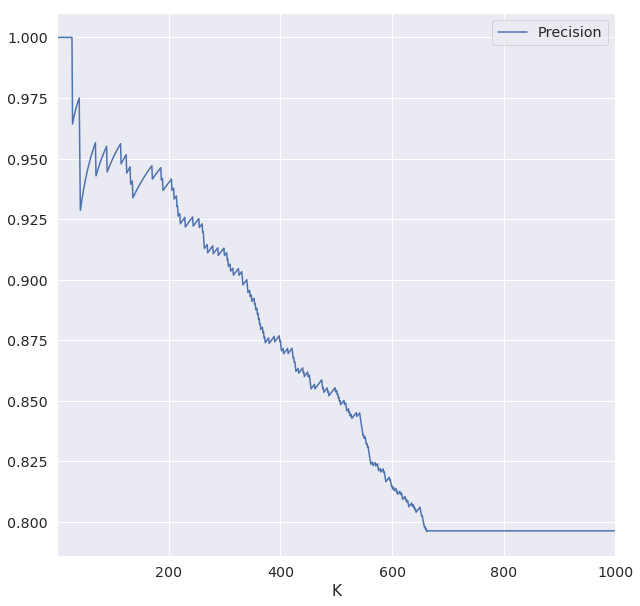

In [487]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
patk_df.plot(0, 1, figsize=(10, 10))

In [488]:
debug = debug.sort("probability")

In [501]:
graph_features[graph_features["originalTitle"]=="The Homesman"][0]

{'tconst': 'tt2398231',
 'titleType': 'movie',
 'primaryTitle': 'The Homesman',
 'originalTitle': 'The Homesman',
 'isAdult': 0,
 'startYear': 2014,
 'endYear': None,
 'runtimeMinutes': 122,
 'genres': 'Drama,Western',
 'appearance-25%': 9.0,
 'appearance-50%': 19.0,
 'appearance-75%': 36.5,
 'appearance-max': 145.0,
 'appearance-mean': 34.266666666666666,
 'appearance-min': 3.0,
 'appearance-std': 40.27134157662186,
 'average_clustering': 0.5977441077441078,
 'average_weighted_clustering': 0.1368430553347621,
 'betweenness-25%': 0.0,
 'betweenness-50%': 0.0,
 'betweenness-75%': 0.02564102564102564,
 'betweenness-max': 0.5146520146520147,
 'betweenness-mean': 0.0652014652014652,
 'betweenness-min': 0.0,
 'betweenness-std': 0.14298756943781468,
 'clique_number': 5,
 'closeness-25%': 0.5185185185185185,
 'closeness-50%': 0.5384615384615384,
 'closeness-75%': 0.5960144927536233,
 'closeness-max': 0.875,
 'closeness-mean': 0.5602766789358493,
 'closeness-min': 0.3888888888888889,
 'closene

In [500]:
(debug[(debug["predicted"] ==0) & (debug["actual"] ==1) ])[0:]

actual,predicted,probability,title
1,0,0.23661971704898932,War on Everyone
1,0,0.2520910006603402,"Young Offenders, The"
1,0,0.25661655252818943,Knights of Badassdom
1,0,0.2600503899741151,Max
1,0,0.2607352824390922,Wonder Wheel
1,0,0.26090178975179973,Minions
1,0,0.2783996089571587,"Danish Girl, The"
1,0,0.27925675051561205,Teenage Mutant NinjaTurtles: Out of the ...
1,0,0.28503332737812026,War Dogs
1,0,0.2873882263166258,First Man


In [490]:
(debug[(debug["predicted"] ==1) & (debug["actual"] ==0) ])[-10:]

actual,predicted,probability,title
0,1,0.8104644156881606,"Spectacular Now, The"
0,1,0.8208667638394561,Never Let Go
0,1,0.8221819657555549,Blair Witch
0,1,0.8238586533970387,"End of the Tour, The"
0,1,0.8307415776805562,Step Up All In
0,1,0.8436227750454005,Better Living ThroughChemistry ...
0,1,0.8490231806198457,Drunk Wedding
0,1,0.8586611911908966,Southside with You
0,1,0.8590280088189195,Life Of Riley
0,1,0.8667886142262102,"Homesman, The"


In [466]:
debug[debug["title"] =='NetThe']

actual,predicted,probability,title


In [2147]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [2151]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index=b.X_train.columns.values,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
3%,0.182496
1%,0.128906
1,0.092849
F_top10,0.081140
0%,0.070245
0,0.065061
f_count,0.063848
3,0.029751
2%,0.024189
Romance,0.010041


In [2150]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=X_train.columns.values,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
3%,0.179843
F_top10,0.104309
1%,0.099907
0%,0.083919
0,0.060027
1,0.045920
f_count,0.040116
3,0.036637
2%,0.022212
Crime,0.012873


Confusion matrix, without normalization
[[280 172]
 [114 434]]
Normalized confusion matrix
[[0.62 0.38]
 [0.21 0.79]]


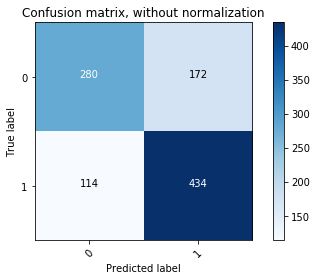

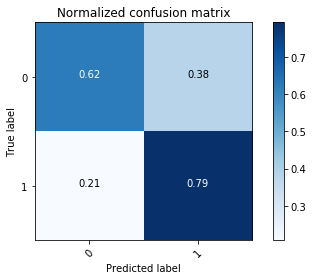

In [232]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = [0, 1]

y_pred = m.predict(X_valid)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred ,labels=class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### T-test

#### Normality Tests

In [1004]:
from scipy.stats import ttest_ind, kstest

In [1081]:
x = np.linspace(-15, 15, 9)
loc, scale = 10, 1
s = np.random.exponential( scale, 10000)
kstest(df.birthYear, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

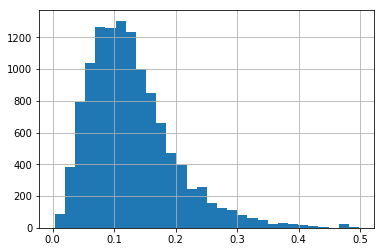

In [68]:
df.pagerank.hist(bins=30)

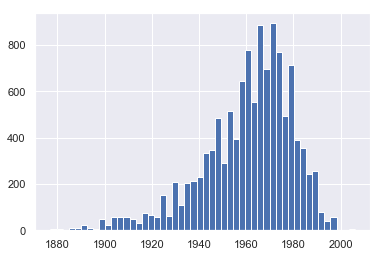

In [1079]:
df.birthYear.hist(bins=50)

In [1091]:
from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)
x = np.concatenate((a, b))
k2, p = stats.normaltest(s)
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.307157
The null hypothesis cannot be rejected


In [59]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(male.age_filming)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


By Gender:

#### Mann-Whitney U test

In [162]:
from scipy.stats import mannwhitneyu

def mannwhitney(data1, data2, alpha = 0.05):
    u_stat, p = mannwhitneyu(data1, data2)
    # print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    if p > alpha:
        return (p,u_stat,data1.median(),data2.median(), 'Same distribution (fail to reject H0)')
    else:
        return (p, u_stat,data1.median(),data2.median(),'Different distribution (reject H0)')

In [189]:
mannwhitney(pd.Series([3,2,1,5,6,8]),pd.Series([1,2,3,5,6,7]))

(0.5, 17.5, 4.0, 4.0, 'Same distribution (fail to reject H0)')

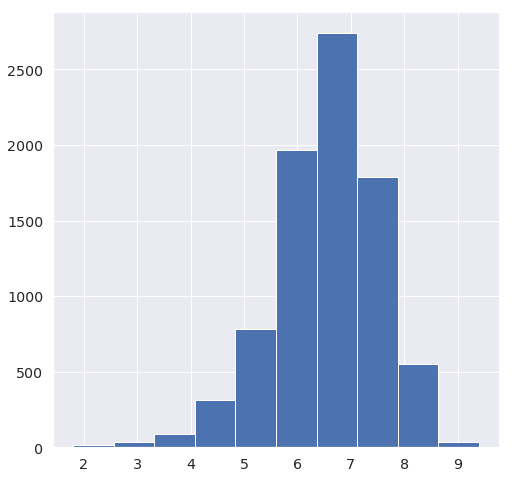

In [184]:
male["movie_rating"].sample(len(female)).hist()

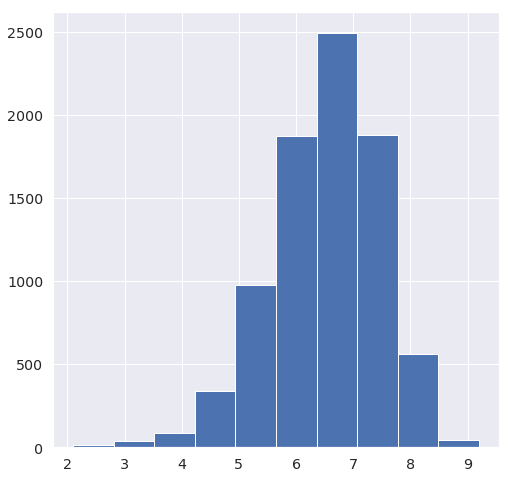

In [182]:
female["movie_rating"].hist()

In [163]:
mwu = []
for col in df.columns.values:
    if "gender" not in col and df[col].dtype != object:
        mwu.append((col,*mannwhitney(male[col], female[col])))

/storage/homedir/dima/miniconda3/envs/subs2graph/lib/python3.6/site-packages/scipy/stats/stats.py:4975: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  "`alternative` is deprecated.", DeprecationWarning)


In [164]:
import re

In [165]:
mwu = pd.DataFrame(mwu,columns=["Feature","p-value","U","Median(M)","Median(F)","Null"])

In [166]:
mwu["Feature"] = mwu.Feature.str.replace("_", " ")
mwu["Feature"] = mwu["Feature"].apply(lambda x: x.title())

In [167]:
mwu.to_csv("mwu.csv")

By genere:

In [168]:
mwu_g = []
for g in genres:
    if len(male[male[g] ==1]) >100 and len(female[female[g] ==1]) >100:
        print(g)
        for col in df.columns.values:
            if "gender" not in col and col not in genres and df[col].dtype != object:
                mwu_g.append((g, col,*mannwhitney(male[male[g] ==1][col], female[female[g] ==1][col])))

War
Biography
Western
Action
Sport
Mystery
Thriller
Sci-Fi
History
Horror
Animation
Drama
Music
Crime
Romance
Family
Comedy
Adventure
Film-Noir
Fantasy
Musical


In [169]:
mwu_g = pd.DataFrame(mwu_g,columns=["Genre", "Feature","p-value","U","Median(M)","Median(F)","Null"])
mwu_g["Feature"] = mwu_g.Feature.str.replace("_", " ")
mwu_g["Feature"] = mwu_g["Feature"].apply(lambda x: x.title())

In [170]:
mwu_g.to_csv("mwu_g.csv")

## Tests

In [1232]:
len(glob.glob(os.path.join(TEMP_PATH, f"movies/*/json/*roles.json")))

13968

In [1218]:
imdb_data.actors[imdb_data.actors["primaryName"]=="Carrie-Anne Moss"]

Columns:
	nconst	str
	averageRating	float
	count	int
	primaryName	str
	birthYear	str
	deathYear	str
	primaryProfession	str
	knownForTitles	str
	gender	str

Rows: Unknown

Data:
+-----------+--------------------+-------+------------------+-----------+-----------+
|   nconst  |   averageRating    | count |   primaryName    | birthYear | deathYear |
+-----------+--------------------+-------+------------------+-----------+-----------+
| nm0005251 | 6.8199999999999985 |   15  | Carrie-Anne Moss |    1967   |     \N    |
+-----------+--------------------+-------+------------------+-----------+-----------+
+-------------------+-------------------------------+--------+
| primaryProfession |         knownForTitles        | gender |
+-------------------+-------------------------------+--------+
|  actress,producer | tt0133093,tt0209144,tt0457... |   F    |
+-------------------+-------------------------------+--------+
[? rows x 9 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [1223]:
t = SFrame.read_csv(f"{TEMP_PATH}/name.basics.tsv.gz", delimiter="\t",
                                                  na_values=["\\N"], nrows=100)

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 0.989886 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int,int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 0.667077 secs.

In [1231]:
t.stack("primaryProfession","primaryProfession")

nconst,primaryName,birthYear,deathYear,knownForTitles,primaryProfession
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",soundtrack
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",actor
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",miscellaneous
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",actress
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",soundtrack
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",actress
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",soundtrack
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",producer
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",actor
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",writer


In [1225]:
t["primaryProfession"] = t["primaryProfession"].apply(lambda x: x.split(","))
t.stack("primaryProfession","primaryProfession")

In [1295]:
imdb_data.all_actors["gender"].summary()


+------------------+---------+----------+
|       item       |  value  | is exact |
+------------------+---------+----------+
|      Length      | 3440575 |   Yes    |
| # Missing Values |    0    |   Yes    |
| # unique values  |    2    |    No    |
+------------------+---------+----------+

Most frequent items:
+-------+---------+
| value |  count  |
+-------+---------+
|   M   | 2161366 |
|   F   | 1279209 |
+-------+---------+


In [1374]:
pd.Series([10, 1,2,3,3, 4,5,6,7,8,9]).rank().astype(int)

0     11
1      1
2      2
3      3
4      3
5      5
6      6
7      7
8      8
9      9
10    10
dtype: int64

In [1365]:
pd.Series([1,2,3,3,3,4, 4,5,6,6,6,6,6,7,8,9]).rank().astype(int)

0      1
1      2
2      4
3      4
4      4
5      6
6      6
7      8
8     11
9     11
10    11
11    11
12    11
13    14
14    15
15    16
dtype: int64

###### Corrolations

In [162]:
female.corr()["age_filming"].sort_values()

birthYear              -0.593557
betweenness            -0.118554
degree_centrality      -0.105639
closeness              -0.098705
Action                 -0.066089
Adventure              -0.062448
Sci-Fi                 -0.060747
Horror                 -0.045146
cinematographer        -0.043658
total_weight           -0.031718
Music                  -0.031586
Fantasy                -0.029533
soundtrack             -0.028327
music_department       -0.028225
composer               -0.027123
director               -0.026245
Thriller               -0.025282
costume_designer       -0.023651
Family                 -0.022892
runtimeMinutes         -0.015810
Romance                -0.015804
Mystery                -0.014943
assistant_director     -0.014116
Sport                  -0.012541
Musical                -0.009829
Film-Noir              -0.009606
Crime                  -0.009007
miscellaneous          -0.008788
Western                -0.003204
casting_director       -0.003013
costume_de

In [163]:
male.corr()["age_filming"].sort_values()

birthYear              -0.958584
producer               -0.051052
degree_centrality      -0.046832
closeness              -0.041025
betweenness            -0.036253
degree                 -0.036160
total_weight           -0.029098
writer                 -0.023755
cinematographer        -0.018555
art_department         -0.015864
camera_department      -0.013812
editorial_department   -0.013516
Fantasy                -0.013271
Music                  -0.012800
Horror                 -0.011247
Sci-Fi                 -0.011221
assistant_director     -0.010835
War                    -0.009415
Adventure              -0.009130
Family                 -0.008221
executive              -0.007916
Film-Noir              -0.006199
Musical                -0.005560
production_manager     -0.004631
Action                 -0.004205
Documentary            -0.003242
director               -0.003231
sound_department       -0.002554
History                -0.002526
Romance                -0.001917
clustering

In [753]:
from sklearn.model_selection import LeaveOneGroupOut

X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


In [756]:
X = [1, 5, 10, 50, 60, 70, 80]
dy = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 1, 1, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[4 5 6] [0 1 2 3]
[0 1 2 3] [4 5 6]


In [217]:
import spacy
%timeit  nlp_sm = spacy.load('en_core_web_sm')

463 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [198]:
import spacy
from spacy import displacy
nlp_sm = spacy.load('en_core_web_sm')

doc2 = nlp_sm("He's saying Corellia?")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_sm("Go and save Chewbacca.")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_sm("Han and I grew up together on Savareen.")
displacy.render(doc2, style='ent', jupyter=True)

In [177]:
import spacy
from spacy import displacy
nlp_md = spacy.load('en_core_web_md')

In [178]:
doc2 = nlp_md("You can see Tiger tonight. - Tiger?")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_md("As you no doubt have guessed...")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_md("...I am Morpheus.")
displacy.render(doc2, style='ent', jupyter=True)

/Users/dimakagan/miniconda3/envs/python3.6/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [179]:
nlp_lg = spacy.load('en_core_web_lg')

In [181]:
import spacy
from spacy import displacy

doc2 = nlp_lg("My name is Tanaka. Please call me Tiger")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_lg("As you no doubt have guessed...")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_lg("...I am Morpheus.")
displacy.render(doc2, style='ent', jupyter=True)

/Users/dimakagan/miniconda3/envs/python3.6/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/Users/dimakagan/miniconda3/envs/python3.6/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [269]:
imdb_data.all_actors

nconst,primaryName,birthYear,deathYear,knownForTitles,primaryProfession,gender
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",actor,M
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",actress,F
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",actress,F
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",actor,M
nm0000005,Ingmar Bergman,1918,2007,"tt0050976,tt0083922,tt0060827,tt0050986 ...",actor,M
nm0000006,Ingrid Bergman,1915,1982,"tt0071877,tt0034583,tt0038787,tt0038109 ...",actress,F
nm0000007,Humphrey Bogart,1899,1957,"tt0033870,tt0043265,tt0037382,tt0034583 ...",actor,M
nm0000008,Marlon Brando,1924,2004,"tt0068646,tt0070849,tt0047296,tt0078788 ...",actor,M
nm0000009,Richard Burton,1925,1984,"tt0087803,tt0061184,tt0057877,tt0059749 ...",actor,M
nm0000010,James Cagney,1899,1986,"tt0029870,tt0031867,tt0035575,tt0055256 ...",actor,M


In [53]:
imdb_data.title[imdb_data.title["primaryTitle"].apply(lambda x: 1 if "Bond" in x else 0)]

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes
tt0000539,short,Bonden i København,Bonden i København,0,1906,None,None
tt0001489,short,The Awakening of JohnBond ...,The Awakening of JohnBond ...,0,1911,None,None
tt0001511,short,Bondefangeri i Vaterland,Bondefangeri i Vaterland,0,1911,None,None
tt0003155,short,The Missing Bonds,The Missing Bonds,0,1913,None,None
tt0003396,short,A Soul in Bondage,A Soul in Bondage,0,1913,None,None
tt0004126,movie,The House of Bondage,The House of Bondage,0,1914,None,None
tt0004990,movie,Bondwomen,Bondwomen,0,1915,None,None
tt0005846,short,Out of Bondage,Out of Bondage,0,1915,None,20
tt0006458,movie,The Bondman,The Bondman,0,1916,None,None
tt0006587,movie,The Devil's Bondwoman,The Devil's Bondwoman,0,1916,None,None


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 100 lines in 1.10157 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,str,str,str,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 1190442 lines. Lines per second: 823415

Read 9496862 lines. Lines per second: 1.35052e+06

Read 16520285 lines. Lines per second: 1.32832e+06

Read 23591041 lines. Lines per second: 1.31375e+06

Read 30700814 lines. Lines per second: 1.31527e+06

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 30924394 lines in 23.5009 secs.

tconst,ordering,nconst,category,job,X6
tt0000001,1,nm1588970,self,None,Herself
tt0000005,1,nm0443482,actor,None,Blacksmith
tt0000005,2,nm0653042,actor,None,Assistant
tt0000008,1,nm0653028,actor,None,Sneezing Man
tt0000009,1,nm0063086,actress,None,Miss Geraldine Holbrook(Miss Jerry) ...
tt0000009,2,nm0183823,actor,None,Mr. Hamilton
tt0000009,3,nm1309758,self,None,Himself - the Director ofthe New York Central ...
tt0000011,1,nm3692297,actor,None,Acrobats
tt0000012,1,nm2880396,self,None,Herself
tt0000012,2,nm9735580,self,None,Himself


In [14]:
james_bond = imdb_data.get_movies_by_character("James Bond")

In [152]:
james_bond_center = SFrame(gender_centrality).join(james_bond, on={"movie_name":"primaryTitle", "year":"startYear" })

In [153]:
james_bond_center

betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality
0.6727272727272727,0.509090909090909,1.0,0.21818181818181814,11,1.0
0.0,0.07272727272727272,0.55,1.0,2,0.18181818181818185
0.0,0.07272727272727272,0.55,1.0,2,0.18181818181818185
0.027272727272727268,0.054545454545454536,0.6111111111111112,0.5,4,0.3636363636363637
0.0,0.0,0.55,1.0,2,0.18181818181818185
0.00909090909090909,0.09090909090909093,0.5789473684210527,0.6666666666666666,3,0.2727272727272727
0.054545454545454536,0.2363636363636364,0.6875,0.5333333333333333,6,0.5454545454545454
0.0,0.0,0.5789473684210527,1.0,3,0.2727272727272727
0.0,0.0,0.55,1.0,2,0.18181818181818185
0.01818181818181818,0.14545454545454545,0.6470588235294118,0.7,5,0.4545454545454546


In [151]:
gender_centrality["movie_name"] = gender_centrality["movie_name"].apply(lambda x: x.replace(" - roles", ""))

In [134]:
import turicreate.aggregate as agg


In [11]:
james_bond_center.groupby(["tconst","year"],{"M":agg.SUM("M"), "F":agg.SUM("F")}).sort("year").explore()

NameError: name 'james_bond_center' is not defined

In [155]:
james_bond_center["tconst","year"].unique()

tconst,year
tt0066995,1971
tt0093428,1987
tt0071807,1974
tt0090264,1985
tt0143145,1999
tt0381061,2006
tt0086006,1983
tt0120347,1997
tt0246460,2002
tt0086034,1983


In [84]:
from shutil import copyfile, rmtree

In [124]:
# movies = imdb_data.get_movies_by_title("Star Wars")
movies = imdb_data.get_movies_by_character("James Bond")

In [85]:
for m in movies:
    movie_name = m["primaryTitle"]
    if os.path.exists(f"{TEMP_PATH}/movies/{movie_name}/json/{movie_name} - roles.json"):
#         print(os.path.exists(f"{TEMP_PATH}/movies/{movie_name}/json/({m['startYear']}) - {movie_name}.png"))
        rmtree(f"{TEMP_PATH}/movies/{movie_name}")
#         copyfile(f"{TEMP_PATH}/movies/{movie_name}/json/{movie_name}.json", f"bond/d3/({m['startYear']}) - {movie_name}.json")

In [18]:
def draw_graph(g, outpath, graph_layout=nx.spring_layout):

    pos = graph_layout(g)
    plt.figure(num=None, figsize=(15, 15), dpi=150)
    plt.axis('off')


    d = dict(nx.degree(g))
    sorted_names = sorted(d.items(), key=lambda  v: (-v[1], v[0]))
    sorted_names = [n for n,v in sorted_names]
    g = g.subgraph(sorted_names)
    d = dict(nx.degree(g))

    
    gender = SFrame(list(g.nodes(data=True))).unpack('X1',  column_name_prefix="").unpack('1', column_name_prefix="")
    gender = gender.to_dataframe()
    gender= gender.set_index('0')
    gender=gender.reindex(g.nodes())
    gender['gender']=pd.Categorical(gender['gender'])
    
    edge_labels = dict([((u, v,), d['weight'])
                    for u, v, d in g.edges(data=True)])

    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
    
    nx.draw(g, pos, node_color=gender["gender"].cat.codes, edge_cmap=plt.cm.Reds, cmap=plt.cm.Set1 ,with_labels=True,  nodelist=d.keys(), node_size=[v * 100 for v in d.values()])
    plt.savefig(outpath)
    plt.close()

In [24]:
from networkx.readwrite import json_graph
import glob

for g_json in glob.glob(f"bond/d3/*.json"):
    with open(g_json) as f:
        g = json_graph.node_link_graph(json.load(f))
        g_name = os.path.basename(g_json).split(".")[0]
        draw_graph(g,f"bond/{g_name}.png")
#         gender = SFrame(list(g.nodes(data=True))).unpack('X1',  column_name_prefix="").unpack('1', column_name_prefix="")

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [16]:
movies = james_bond

In [23]:
for m in movies:
    movie_name = m["primaryTitle"]
    try:
        add_gender_to_graph(movie_name, False)
    except:
        pass

In [91]:
for m in movies.sort("startYear"):
    movie_name = m["primaryTitle"]
    print(f'<option value="({m["startYear"]}) - {movie_name}">{m["startYear"]}-{movie_name}</option>')

<option value="(1977) - Star Wars: Episode IV - A New Hope">1977-Star Wars: Episode IV - A New Hope</option>
<option value="(1980) - Star Wars: Episode V - The Empire Strikes Back">1980-Star Wars: Episode V - The Empire Strikes Back</option>
<option value="(1983) - Star Wars: Episode VI - Return of the Jedi">1983-Star Wars: Episode VI - Return of the Jedi</option>
<option value="(1999) - Star Wars: Episode I - The Phantom Menace">1999-Star Wars: Episode I - The Phantom Menace</option>
<option value="(2002) - Star Wars: Episode II - Attack of the Clones">2002-Star Wars: Episode II - Attack of the Clones</option>
<option value="(2005) - Star Wars: Episode III - Revenge of the Sith">2005-Star Wars: Episode III - Revenge of the Sith</option>
<option value="(2008) - Star Wars: The Clone Wars">2008-Star Wars: The Clone Wars</option>
<option value="(2015) - Star Wars: The Force Awakens">2015-Star Wars: The Force Awakens</option>
<option value="(2016) - Rogue One: A Star Wars Story">2016-Rogue

In [158]:
james_bond[""]

averageRating,numVotes,primaryTitle,startYear,tconst
6.8,341093,Spectre,2015,tt2379713
7.0,92556,Thunderball,1965,tt0059800
6.7,83937,Diamonds Are Forever,1971,tt0066995
7.7,154559,Goldfinger,1964,tt0058150
6.5,164461,Tomorrow Never Dies,1997,tt0120347
7.1,86710,The Spy Who Loved Me,1977,tt0076752
5.2,24412,Casino Royale,1967,tt0061452
7.3,130518,Dr. No,1962,tt0055928
6.6,83475,Licence to Kill,1989,tt0097742
8.0,525886,Casino Royale,2006,tt0381061


In [71]:
from fuzzywuzzy.fuzz import *
from fuzzywuzzy import process
from Levenshtein import ratio as lratio

In [77]:
{1:2,3:4}.keys()

dict_keys([1, 3])

In [25]:
partial_ratio("Don Vito Corlonee", "Vito Don")

75

In [74]:
lratio("Don", "Corlonee Vito Don")

0.3

In [98]:
WRatio("Don", "Don Jon")

0.6

In [75]:
None[0]

TypeError: 'NoneType' object is not subscriptable

In [87]:
choices = ["Don Vito Corleone", "Michael Corleone", "Michael"]
list(process.extractWithoutOrder("Don Corleone", choices))

[('Don Vito Corleone', 95), ('Michael Corleone', 76), ('Michael', 26)]

In [55]:
ratio("Dona Vitor", "Vito Don")

44

In [53]:
ratio("Don Vito", "Dona Vitor")

0.8888888888888888

In [47]:
set(full_process("Dona Vitor").split())

{'dona', 'vitor'}

In [8]:
from subs2graph.video_roles_analyzer import tmdb
tmdb.API_KEY = os.getenv('TMD_API_KEY')


/Users/dimakagan/Projects/subs2graph/subs2graph/video_roles_analyzer.py:79: DeprecationWarning: invalid escape sequence \w
  re_possessive = re.compile("(\w+\'s\s+\w+|\w+s\'\s+\w+)")
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/dogpile/cache/util.py:31: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(fn)


In [9]:
external_source = 'imdb_id'
find = tmdb.Find("tt2379713")
resp = find.info(external_source=external_source)
m_id = resp['movie_results'][0]['id']
m = tmdb.Movies(m_id)

for person in m.credits()['cast']:
    if not "uncredited" in person['character']:
        print(f"{person['order']} {person['id']} {person['name']}| {person['character']}| {person['profile_path']}")

0 8784 Daniel Craig| James Bond| /mr6cdu6lLRscfFUv8onVWZqaRdZ.jpg
1 27319 Christoph Waltz| Ernst Stavro Blofeld| /2Hhztd4mUEV9Y25rfkXDwzL9QI9.jpg
2 121529 Léa Seydoux| Dr. Madeleine Swann| /xptyFXfBENBMQkgPEYCxlMkSLSs.jpg
3 5469 Ralph Fiennes| Gareth Mallory / M| /d2vvUY7bzEbNRXInVVwuyHkN6Bz.jpg
4 28782 Monica Bellucci| Lucia Sciarra| /nkrIGojQy6FNn9s5cfpiUAmLeNz.jpg
5 17064 Ben Whishaw| Q| /e74Cz65ifeNb9zHfUTvF5rTix0d.jpg
6 2038 Naomie Harris| Eve Moneypenny| /41TVAcYqKKF7PGf3x7QfaLvkLSW.jpg
7 543530 Dave Bautista| Mr. Hinx| /oZDL1VprkUEFhOtG5WcVjudj5ks.jpg
8 125660 Andrew Scott| Max Denbigh / C| /3yu4zC3OVq2lvmMqnPT4RYH4sBU.jpg
9 139549 Rory Kinnear| Tanner| /x6S1iZAHHjtPCCyYKOVMOea6zbU.jpg
10 2244 Jesper Christensen| Mr. White| /fnE1D2BtNex0bUZE4DdxAsju0YR.jpg
11 1381616 Alessandro Cremona| Marco Sciarra| /qhJDXXELVYFIl5wBCuWjznL1Xk6.jpg
12 929937 Stephanie Sigman| Estrella| /9ZOVeNIGXziOXBSDNu60pvzuKrs.jpg
13 87265 Tenoch Huerta| Mexican Man in Lift| /3wGFejGaiDp65z4CrDZaItsPKgC.jp

In [116]:
person

{'cast_id': 64,
 'character': 'Police (uncredited)',
 'credit_id': '58d8007ac3a368125f058021',
 'gender': 0,
 'id': 1784215,
 'name': 'Bedri Çavusoglu',
 'order': 44,
 'profile_path': None}

In [22]:
from itertools import combinations
list(combinations(["x"],1))

[('x',)]

In [208]:
graph_features.column_names

<bound method SFrame.column_names of Columns:
	appearance-25%	float
	appearance-50%	float
	appearance-75%	float
	appearance-max	float
	appearance-mean	float
	appearance-min	float
	appearance-std	float
	average_clustering	float
	average_weighted_clustering	float
	betweenness-25%	float
	betweenness-50%	float
	betweenness-75%	float
	betweenness-max	float
	betweenness-mean	float
	betweenness-min	float
	betweenness-std	float
	clique_number	int
	closeness-25%	float
	closeness-50%	float
	closeness-75%	float
	closeness-max	float
	closeness-mean	float
	closeness-min	float
	closeness-std	float
	degree-25%	float
	degree-50%	float
	degree-75%	float
	degree-max	float
	degree-mean	float
	degree-min	float
	degree-std	float
	edge_number	int
	f_count	int
	imdb_rating	float
	m_count	int
	movie_name	str
	node_number	int
	pagerank-25%	float
	pagerank-50%	float
	pagerank-75%	float
	pagerank-max	float
	pagerank-mean	float
	pagerank-min	float
	pagerank-std	float
	weight-25%	float
	weight-50%	float
	weight-75

In [210]:
graphs_meta= graph_features[["average_clustering","movie_name","year","node_number","edge_number","weight-mean"]]

In [205]:
datavers = SFrame.read_csv(f"{DATA_PATH}/dataverse_files/network_metadata.tsv",delimiter='\t')

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/dataverse_files/network_metadata.tsv

Parsing completed. Parsed 100 lines in 0.02902 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,int,str,str,str,str,str,str,str,str,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/data/dataverse_files/network_metadata.tsv

Parsing completed. Parsed 773 lines in 0.007317 secs.

In [212]:
comp = datavers.join(graphs_meta,{"ReleaseDate":"year","Title":"movie_name"})

In [215]:
comp.sort("edge_number", False)

GexfID,Title,IMDB_id,ReleaseDate,Slug,WeightedDegree,Modularity
456,JFK,tt0102138,1991,JFK,"7,256","0,480"
523,Magnolia,tt0175880,1999,Magnolia,"8,022","0,663"
356,The Godfather: Part II,tt0071562,1974,The-Godfather:-Part-II,"6,903","0,516"
178,Casino,tt0112641,1995,Casino,"9,628","0,415"
659,Public Enemies,tt1152836,2009,Public-Enemies,"6,929","0,453"
355,The Godfather,tt0068646,1972,The-Godfather,"8,476","0,329"
52,American Gangster,tt0765429,2007,American-Gangster,"5,031","0,418"
509,Lone Star,tt0116905,1996,Lone-Star,"6,453","0,458"
715,Scream 3,tt0134084,2000,Scream-3,"11,548","0,229"
586,Nashville,tt0073440,1975,Nashville,"9,073","0,359"


In [216]:
len(imdb_data.rating[imdb_data.rating["numVotes"] > 5000])

14237

In [229]:
sorted([(f, os.path.getmtime(f"{TEMP_PATH}/movies/{f}")) for f in os.listdir(f"{TEMP_PATH}/movies/")],key=lambda x: x[1])

[('Pariyerum Perumal', 1550387781.911832),
 ('Yowis Ben', 1550387778.0534527),
 ('Maya Bazaar', 1550387777.966828),
 ('CM101MMXI Fundamentals', 1550387758.6164668),
 ('The Shawshank Redemption', 1550387743.0747824),
 ('Co Kancharapalem', 1550387725.616148),
 ('The Chaos Class', 1550387725.5236688),
 ('Jibon Thekey Neya', 1550387698.2933965),
 ('Ekvtime: Man of God', 1550387695.1593575),
 ('The Phantom of the Opera at the Royal Albert Hall', 1550048113.353198),
 ('Anand', 1549995906.7254508),
 ('Aloko Udapadi', 1549995585.546239),
 ('.DS_Store', 1549969488.6791859),
 ('The Imitation Game ', 1549969488.5983143),
 ('The Imitation Game', 1549969319.430111),
 ('Skyfall', 1549531726.4086592),
 ('Tomorrow Never Dies', 1549462739.035542),
 ('Star Wars: Episode V - The Empire Strikes Back', 1549446761.0762215),
 ('Star Wars: The Clone Wars', 1549446736.1868489),
 ('Star Wars: The Force Awakens', 1549446693.2223742),
 ('Star Wars: Episode VI - Return of the Jedi', 1549446669.4847941),
 ('Star Wa

In [230]:
!ls -lt ../temp/movies/ | head -10

total 0
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:16 Pariyerum Perumal
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:16 Yowis Ben
drwxr-xr-x   7 dimakagan  staff  224 Feb 17 09:16 Maya Bazaar
drwxr-xr-x   7 dimakagan  staff  224 Feb 17 09:15 CM101MMXI Fundamentals
drwxr-xr-x   9 dimakagan  staff  288 Feb 17 09:15 The Shawshank Redemption
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:15 Co Kancharapalem
drwxr-xr-x   7 dimakagan  staff  224 Feb 17 09:15 The Chaos Class
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:14 Jibon Thekey Neya
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:14 Ekvtime: Man of God


In [23]:
from subs2graph.videos_sn_creator import generate_blacklist_roles

In [45]:
generate_blacklist_roles()

In [56]:
sf = SFrame.read_csv(f"{TEMP_PATH}/roles3.csv")
sf=sf[sf["character"]!=""]


Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/roles3.csv

Parsing completed. Parsed 100 lines in 1.39928 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,str,str,str,str,int,int,str,int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 543813 lines. Lines per second: 682896

Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/roles3.csv

Parsing completed. Parsed 1633409 lines in 2.50654 secs.

character,nconst,count
Comedian,nm0103977,85
Gene Autry,nm0000810,78
Roy Rogers,nm0001678,66
Hopalong Cassidy,nm0101955,59
Frog Millhouse,nm0122470,49
The Durango Kid,nm0823633,47
Santo,nm0763803,42
Capulina,nm0376228,41
Cannonball,nm0852305,39
Narrator,nm0589498,38


In [57]:
sf2 = sf.groupby(key_column_names=['character', "nconst"],
                           operations={'count': agg.COUNT()}).sort("count",False)

In [62]:
sf2[sf2["character"]=="Father"]

character,nconst,count
Father,nm0534535,3
Father,nm0459303,2
Father,nm0001354,2
Father,nm1026161,2
Father,nm0536954,2
Father,nm9399341,2
Father,nm0001831,2
Father,nm0642148,2
Father,nm0028222,2
Father,nm0698653,2


In [54]:
sf=sf[sf["character"]!=""]]

SyntaxError: invalid syntax (<ipython-input-54-314cd7fcce5b>, line 1)

In [46]:
b_list = SFrame.read_csv(f"{TEMP_PATH}/roles.csv").sort("count",False)

Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/roles.csv

Parsing completed. Parsed 100 lines in 0.27423 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/subs2graph/temp/roles.csv

Parsing completed. Parsed 585587 lines in 0.155866 secs.

In [50]:
b_list.sort("count",False).print_rows(30)

+----------------+----------+-------+
|   character    | ordering | count |
+----------------+----------+-------+
|    Teacher     | 4.02508  |  319  |
|     Hannah     | 3.06061  |  297  |
|    Waitress    | 4.31973  |  294  |
|  Interviewee   | 3.17073  |  246  |
|     Justin     |   2.9    |  200  |
|     Kathy      | 3.15979  |  194  |
|     Ronnie     | 2.89418  |  189  |
|     Waiter     | 4.07937  |  189  |
|      Ruby      | 3.10056  |  179  |
|   Secretary    | 4.44118  |  170  |
|    Matthew     | 2.92727  |  165  |
|     Blake      | 3.23313  |  163  |
|    Miranda     | 2.83766  |  154  |
| Security Guard | 4.16901  |  142  |
|     Penny      | 3.28571  |  140  |
|     Killer     | 3.13869  |  137  |
|     Gordon     | 3.10526  |  133  |
|  Taxi Driver   | 4.53788  |  132  |
|      Kat       | 3.11364  |  132  |
|      Leah      | 2.78626  |  131  |
|     Kenny      | 3.33071  |  127  |
|     Flora      | 3.51613  |  124  |
|     Erika      | 2.89431  |  123  |
|     Amelia